# Biddy <i>et al.</i>, 2018 Dataset
Single-cell mapping of lineage and identity in direct reprogramming


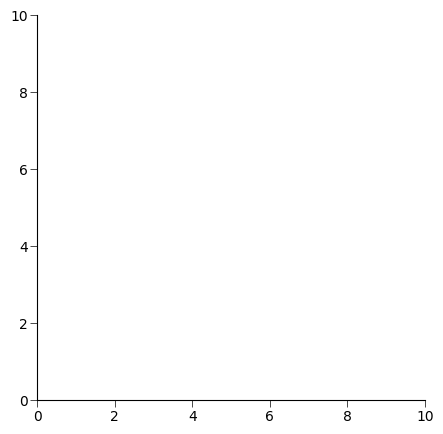

In [3]:
import scanpy as sc
import numpy as np
import operator
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import os
from torch.nn import DataParallel
import os
import anndata as ad
import cospar as cs
import scanpy as sc
def createFig(figsize=(8, 4)):
    fig,ax=plt.subplots()           
    ax.spines['right'].set_color('none')     
    ax.spines['top'].set_color('none')
    #ax.spines['bottom'].set_color('none')     
    #ax.spines['left'].set_color('none')
    for line in ax.yaxis.get_ticklines():
        line.set_markersize(5)
        line.set_color("#585958")
        line.set_markeredgewidth(0.5)
    for line in ax.xaxis.get_ticklines():
        line.set_markersize(5)
        line.set_markeredgewidth(0.5)
        line.set_color("#585958")
    ax.set_xbound(0,10)
    ax.set_ybound(0,10)
    fig.set_size_inches(figsize)
    return fig,ax
def setPltLinewidth(linewidth:float):
    mpl.rcParams['axes.linewidth'] = linewidth
import matplotlib as mpl
fig,ax=createFig()
fig.set_size_inches(5,5)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
setPltLinewidth(1)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1
##setting draw parameters

In [2]:

adata_orig=cs.hf.read('/home/zhengtuo/songtao/newbiddy_pcg2.h5ad')
adata_orig.obs['index']=0
adata_orig.obs['index']=adata_orig.obs.index.astype(int)

In [4]:
adata3=sc.read('./biddy_for_ziwei_2.23.h5ad')
adata3

AnnData object with n_obs × n_vars = 13754 × 20864
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'index', 'barceode_0_3', 'time'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'neighbors', 'state_info_colors', 'time_info_colors', 'time_ordering', 'umap'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_emb_old', 'X_pca', 'X_umap', 'geneEnc', 'genemap'
    obsp: 'connectivities', 'distances'

In [31]:
biddy_adata_all = sc.read_h5ad('../newbiddy_pcg_nolog2.h5ad')
sc.pp.log1p(biddy_adata_all)
adata3.raw = biddy_adata_all[adata3.obs.index,adata3.var.index]

In [18]:
###### from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from math import sqrt
from random import choice
from torch.utils.data  import Dataset, DataLoader
import pandas as pd
#from layers import SinkhornDistance
num_relations=4
len_geneExp=20864
len_embedding=256
learning_rate=0.0001
num_epoch=100
batchsize=512
# TwoNets_path='/data/songtao/newdata-biddy.pth'

criterion_rec = nn.MSELoss()
geneEnc=nn.Sequential(
    nn.Dropout(),
    nn.Linear(len_geneExp, 100),
    nn.ReLU(),
            nn.Linear(100, 100),
             nn.ReLU(),
     nn.Linear(100, 100),
             nn.ReLU(),
    nn.Linear(100, 100),
             nn.ReLU(),
    nn.Linear(100, len_embedding),

)
geneDec = nn.Sequential(
    nn.Linear(len_embedding, len_geneExp),
    #nn.Linear(512, len_geneExp),
)
genemap=nn.Sequential(
#nn.Dropout(0.1),
    nn.Linear(len_embedding, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, len_embedding),

)
from math import sqrt

import torch
import torch.nn as nn
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.LeakyReLU(inplace=False),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        #print('channel:',c)
        #print('size:',x.shape)
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        #print('y_size:',y.shape)
        return x * y.expand_as(x)
class MutiheadAttention(nn.Module):
    def __init__(self, input_dim, dim_k, dim_v,num_heads):
        super(MutiheadAttention, self).__init__()
        self.dim_q = dim_k 
        self.dim_k = dim_k
        self.dim_v = dim_v
        self.num_units=dim_k
        self.num_heads=num_heads
        self.linear_q = nn.Linear(input_dim, dim_k, bias=False)
        self.linear_k = nn.Linear(input_dim, dim_k, bias=False)
        self.linear_v = nn.Linear(input_dim, dim_v, bias=False)
        self._norm_fact = 1 / sqrt(dim_k)

    def forward(self, x):
        # x: batch_size, seq_len, input_dim
        q = self.linear_q(x)  # batch_size, seq_len, dim_k
        k = self.linear_k(x)  # batch_size, seq_len, dim_k
        v = self.linear_v(x)  # batch_size, seq_len, dim_v
        split_size = self.num_units // self.num_heads
        q = torch.stack(torch.split(q, split_size, dim=2), dim=0)  # [h, N, T_q, num_units/h]
        k = torch.stack(torch.split(k, split_size, dim=2), dim=0)  # [h, N, T_k, num_units/h]
        v = torch.stack(torch.split(v, split_size, dim=2), dim=0)  # [h, N, T_k, num_units/h]

        scores = torch.matmul(q, k.transpose(2, 3))
        scores = scores / (self.dim_k ** 0.5)
        
        scores = F.softmax(scores, dim=3)
        ## out = score * V
        out = torch.matmul(scores, v)  # [h, N, T_q, num_units/h]
        out = torch.cat(torch.split(out, 1, dim=0), dim=3).squeeze(0) 

        return out


device = torch.device("cuda")
device2 = torch.device("cuda")

class ResidualBlock(torch.nn.Module):
    def __init__(self,channels):
        super(ResidualBlock,self).__init__()
        self.channels = channels
        
        self.conv1 = nn.Conv1d(channels,channels,kernel_size=3,padding=1)
        self.conv2 = nn.Conv1d(channels,channels,kernel_size=3,padding=1)
        self.se=SELayer(channels,16)
    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.conv2(y)
        y=self.se(y)
        return F.relu(x+y)

class model(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.att=MutiheadAttention(len_embedding*2,512,512,64)
        self.layernorm=nn.LayerNorm(512)
        self.conv1 = nn.Conv1d(1, 32, 4) 
        self.relu1=nn.LeakyReLU(0.2, inplace=True)
        self.rblock1 = ResidualBlock(32)
        self.conv2 = nn.Conv1d(32,64, 4)  
        self.batchn1=nn.BatchNorm1d(64)
        self.relu2= nn.LeakyReLU(0.2, inplace=True)
        self.rblock2 = ResidualBlock(64)
        self.conv3=nn.Conv1d(64,128,4)
        self.batchn2=nn.BatchNorm1d(128)
        self.relu3= nn.LeakyReLU(0.2, inplace=True)
        self.rblock3 = ResidualBlock(128)
        self.conv4=nn.Conv1d(128,256,4)
        self.batchn3=nn.BatchNorm1d(256)
        self.relu4= nn.LeakyReLU(0.2, inplace=True)
        self.rblock4 = ResidualBlock(256)
        #self.dropout=nn.Dropout()
        self.fc1 = nn.Linear(7424, num_relations)
        
    def forward(self, x):
        x=self.att(x)+x
        x=self.layernorm(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock1(x)
        x = self.conv2(x)
        x=self.batchn1(x)
        x=self.relu2(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock2(x)
        
        x = self.conv3(x)
        x=self.batchn2(x)
        x=self.relu3(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock3(x)
        
        x = self.conv4(x)
        x=self.batchn3(x)
        x=self.relu4(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock4(x)
        x = x.view(x.size()[0], -1)
        #x=self.dropout(x)
        x=self.fc1(x)
        return x
model=model()
optimizer = torch.optim.Adam(
    [{'params': geneEnc.parameters()},
    {'params': model.parameters()},
        {'params': geneDec.parameters()},
    #{'params': norelmodel.parameters()},
            {'params': genemap.parameters()}],
    lr=learning_rate)

class TrainDataset(Dataset):
    def __init__(self,length):
        self.length=length

    def __getitem__(self, idx):
        cell1_id=int(traincell1[idx])
        cell2_id=int(traincell2[idx])
        gene1=adata_orig.X[cell1_id].toarray()
        gene1=torch.tensor(gene1)
        gene2=adata_orig.X[cell2_id].toarray()
        gene2=torch.tensor(gene2)       
        genetype=train_rel[idx]
        #genetype=dic1[genetype]
        genetype=torch.tensor(genetype)
        
        
        return gene1,gene2,genetype

    def __len__(self):
        return self.length

model.to(device)
geneEnc.to(device)
genemap.to(device)
geneDec.to(device)
from sklearn.metrics import confusion_matrix
TwoNets_path='/home/zhengtuo/songtao/newdata-biddy2.pth'
checkpoint = torch.load(TwoNets_path,map_location='cuda:2')
device2 = torch.device("cuda:2")
model.load_state_dict(checkpoint['model'])
model.to(device2)
geneEnc.load_state_dict(checkpoint['geneEnc'])
geneEnc.to(device2)
geneDec.load_state_dict(checkpoint['geneDec'])
geneDec.to(device2)

model.eval()
geneEnc.eval()
geneDec.eval()

genemap.load_state_dict(checkpoint['genemap'])
genemap.to(device2)
genemap.eval()

Sequential(
  (0): Linear(in_features=256, out_features=100, bias=True)
  (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=100, out_features=256, bias=True)
)

/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


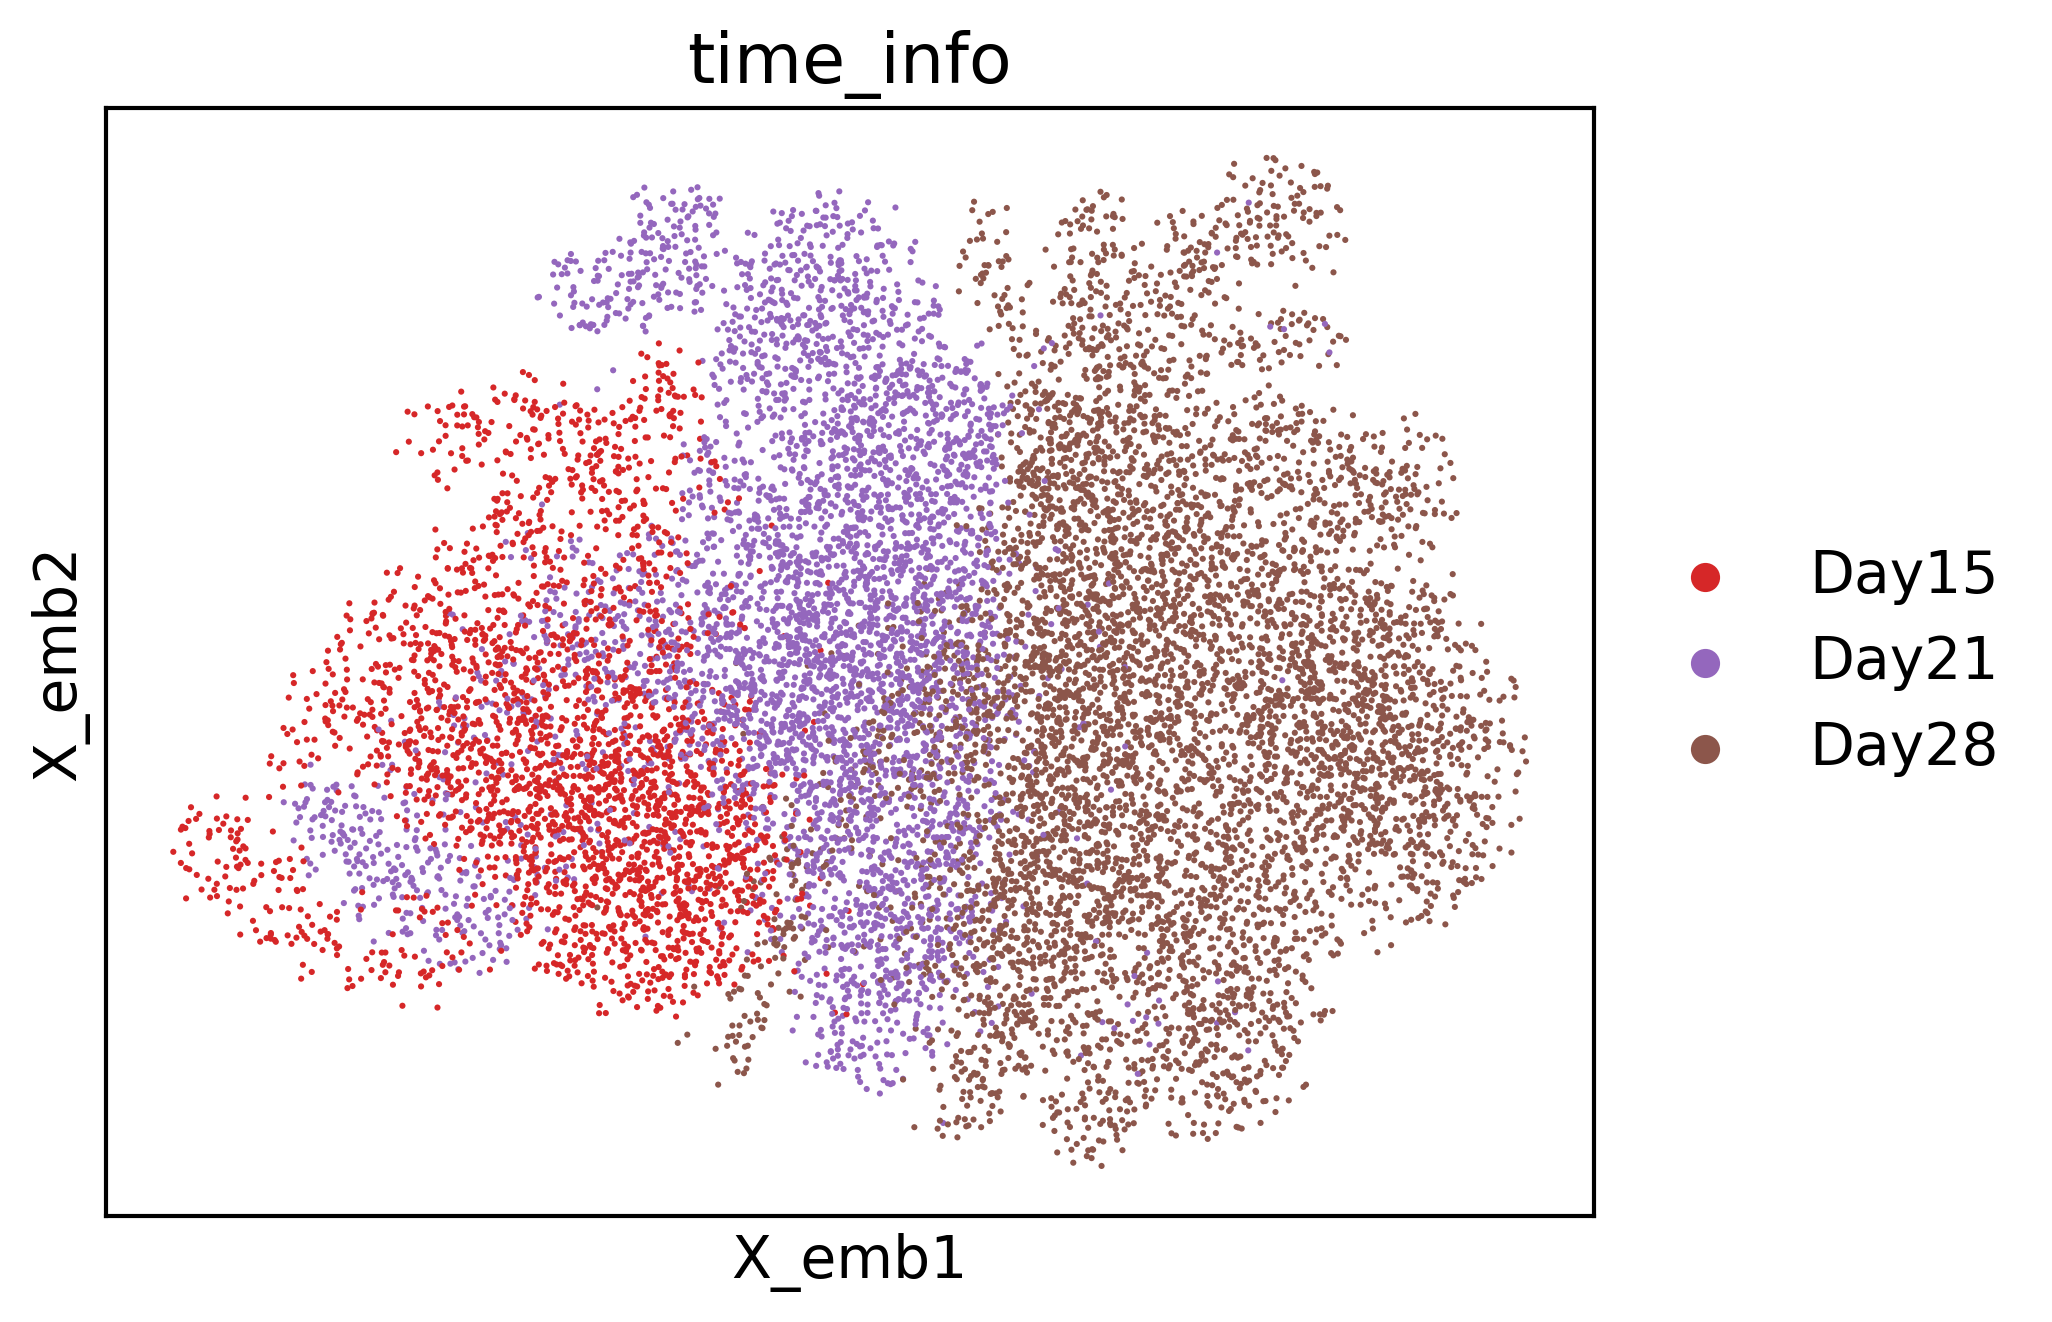

/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


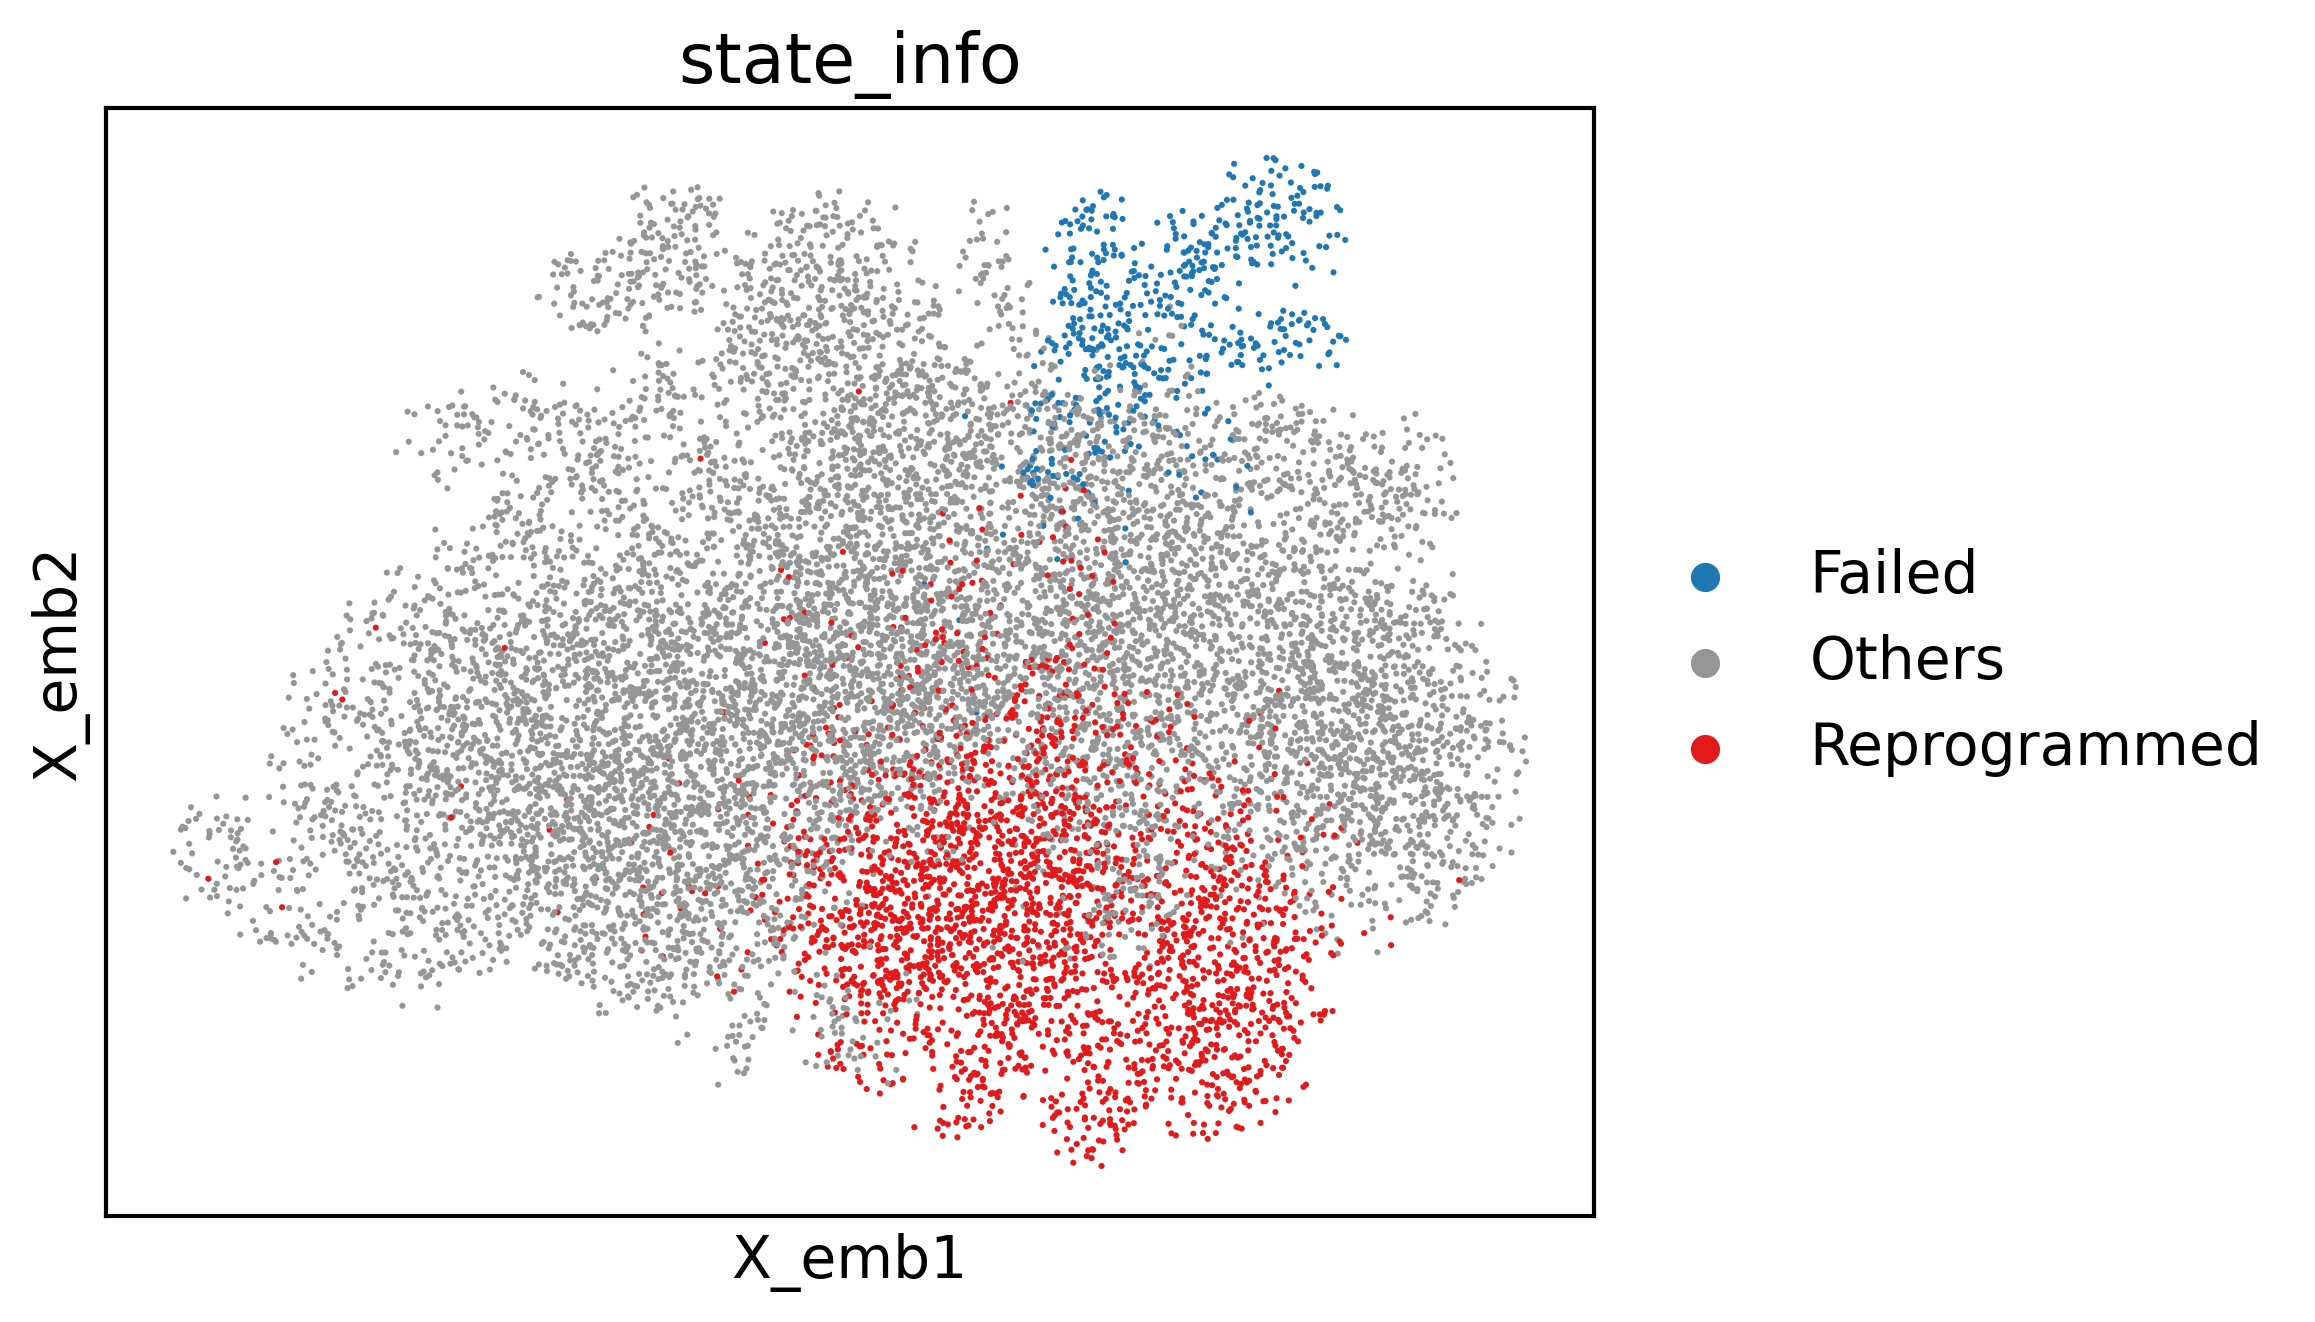

In [7]:
cs.pl.embedding(adata3, color="time_info")
cs.pl.embedding(adata3, color="state_info")

100%|████████████████████████████████████| 13754/13754 [01:56<00:00, 118.54it/s]


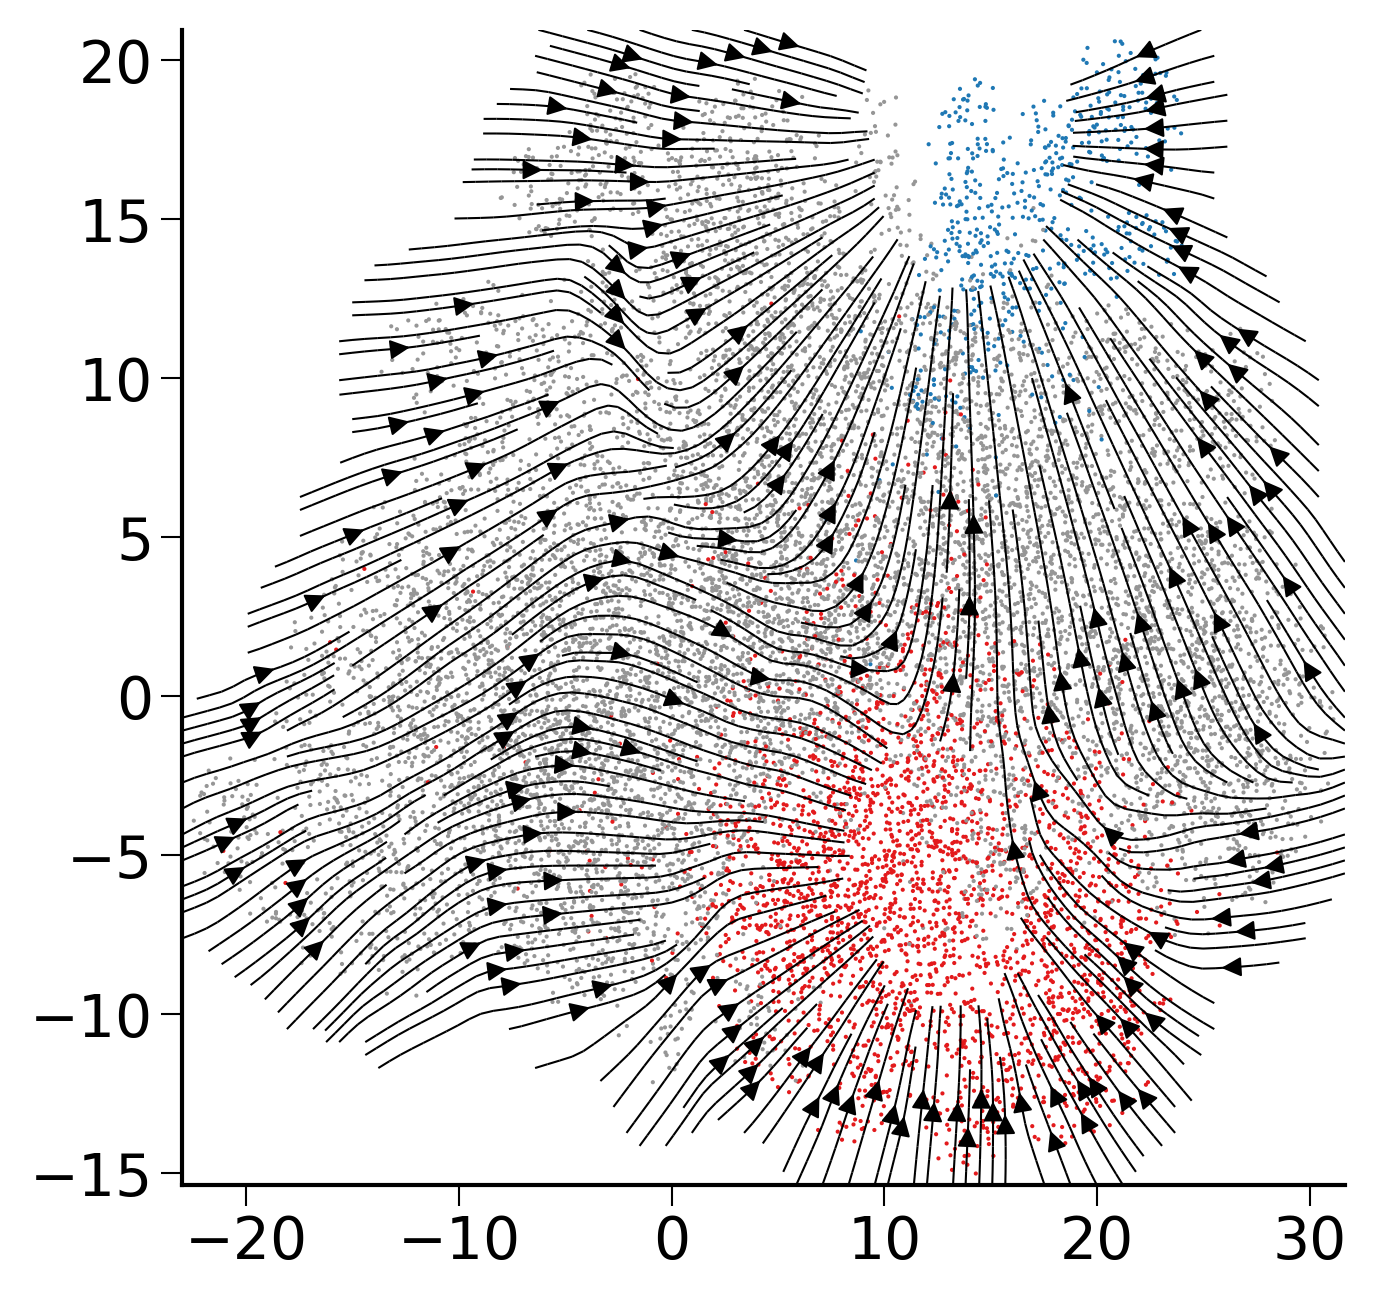

In [8]:
def compute_velocity_on_grid(
    X_emb,
    M_emb,
    density=None,
    smooth=None,
    n_neighbors=None,
    min_mass=None,
    autoscale=True,
    adjust_for_stream=False,
    cutoff_perc=None,
):
    # remove invalid cells
    idx_valid = np.isfinite(X_emb.sum(1) + M_emb.sum(1))
    X_emb = X_emb[idx_valid]
    M_emb = M_emb[idx_valid]

    # prepare grid
    n_obs, n_dim = X_emb.shape
    density = 0.5 if density is None else density
    smooth = 0.5 if smooth is None else smooth

    grs = []
    for dim_i in range(n_dim):
        m, M = np.min(X_emb[:, dim_i]), np.max(X_emb[:, dim_i])
        m = m - 0.01 * np.abs(M - m)
        M = M + 0.01 * np.abs(M - m)
        gr = np.linspace(m, M, int(50 * density))
        grs.append(gr)

    meshes_tuple = np.meshgrid(*grs)
    X_grid = np.vstack([i.flat for i in meshes_tuple]).T

    # estimate grid velocities
    if n_neighbors is None:
        n_neighbors = int(n_obs / 50)
    nn = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
    nn.fit(X_emb)
    dists, neighs = nn.kneighbors(X_grid)

    scale = np.mean([(g[1] - g[0]) for g in grs]) * smooth
    weight = normal.pdf(x=dists, scale=scale)
    p_mass = weight.sum(1)

    V_grid = (M_emb[neighs] * weight[:, :, None]).sum(1)
    V_grid /= np.maximum(1, p_mass)[:, None]
    if min_mass is None:
        min_mass = 1

    if adjust_for_stream:
        X_grid = np.stack([np.unique(X_grid[:, 0]), np.unique(X_grid[:, 1])])
        ns = int(np.sqrt(len(V_grid[:, 0])))
        V_grid = V_grid.T.reshape(2, ns, ns)

        mass = np.sqrt((V_grid ** 2).sum(0))
        min_mass = 10 ** (min_mass - 6)  # default min_mass = 1e-5
        min_mass = np.clip(min_mass, None, np.max(mass) * 0.9)
        cutoff = mass.reshape(V_grid[0].shape) < min_mass

        if cutoff_perc is None:
            cutoff_perc = 5
        length = np.sum(np.mean(np.abs(M_emb[neighs]), axis=1), axis=1).T
        length = length.reshape(ns, ns)
        cutoff |= length < np.percentile(length, cutoff_perc)

        V_grid[0][cutoff] = np.nan
    else:
        min_mass *= np.percentile(p_mass, 99) / 100
        X_grid, V_grid = X_grid[p_mass > min_mass], V_grid[p_mass > min_mass]

        if autoscale:
            V_grid /= 3 * quiver_autoscale(X_grid, V_grid)

    return X_grid, V_grid

def quiver_autoscale(X_emb, V_emb):
    import matplotlib.pyplot as pl

    scale_factor = np.abs(X_emb).max()  # just so that it handles very large values
    fig, ax = pl.subplots()
    Q = ax.quiver(
        X_emb[:, 0] / scale_factor,
        X_emb[:, 1] / scale_factor,
        V_emb[:, 0],
        V_emb[:, 1],
        angles="xy",
        scale_units="xy",
        scale=None,
    )
    Q._init()
    fig.clf()
    pl.close(fig)
    return Q.scale / scale_factor
import numpy as np
from scipy.stats import norm as normal
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import NearestNeighbors
import tqdm
sc.pp.neighbors(adata3)
X = adata3.obsm['geneEnc'][:,0,:]
M = adata3.obsm['genemap'][:,0,:]
N = adata3.obsp['connectivities']
E = adata3.obsm["X_umap"]
norm = lambda x: (x-min(x))/(max(x)-min(x))

nn = NearestNeighbors(n_neighbors=5)
nn.fit(X)
dE = []
for i in tqdm.trange(N.shape[0]):
    D,I = nn.kneighbors( np.array([M[i]]) )
    dE.append( (E[I][0] - E[i]).mean(0))
dE = np.vstack(dE)
gE, gdE = compute_velocity_on_grid(E,dE,density=2, adjust_for_stream=True,smooth=True)
fig,ax=createFig()
fig.set_size_inches(5,5)
palette = sc.pl._tools.scatterplots._get_palette(adata3, 'state_info')
ax.scatter(E[:,0],E[:,1],s=1, linewidths=0,c=list(map(lambda x: palette[x], adata3.obs['state_info'])))
stream_kwargs = {
        "linewidth": 0.5,
        "density": 3,
        "zorder": 3,
        "color": "black",
        "arrowsize":  1,
    
        "arrowstyle": "-|>",
        "maxlength":  10,
        "integration_direction":  "both",
}
ax.streamplot(gE[0],gE[1],gdE[0],gdE[1],**stream_kwargs)



In [7]:
import pickle
f_read = open('./dic_fate_biddy_ourmodel.pkl', 'rb')
b = pickle.load(f_read)
adata3.obs['fate_pred']=None
adata3.obs['fate_pred']=adata3.obs['index'].map(b)

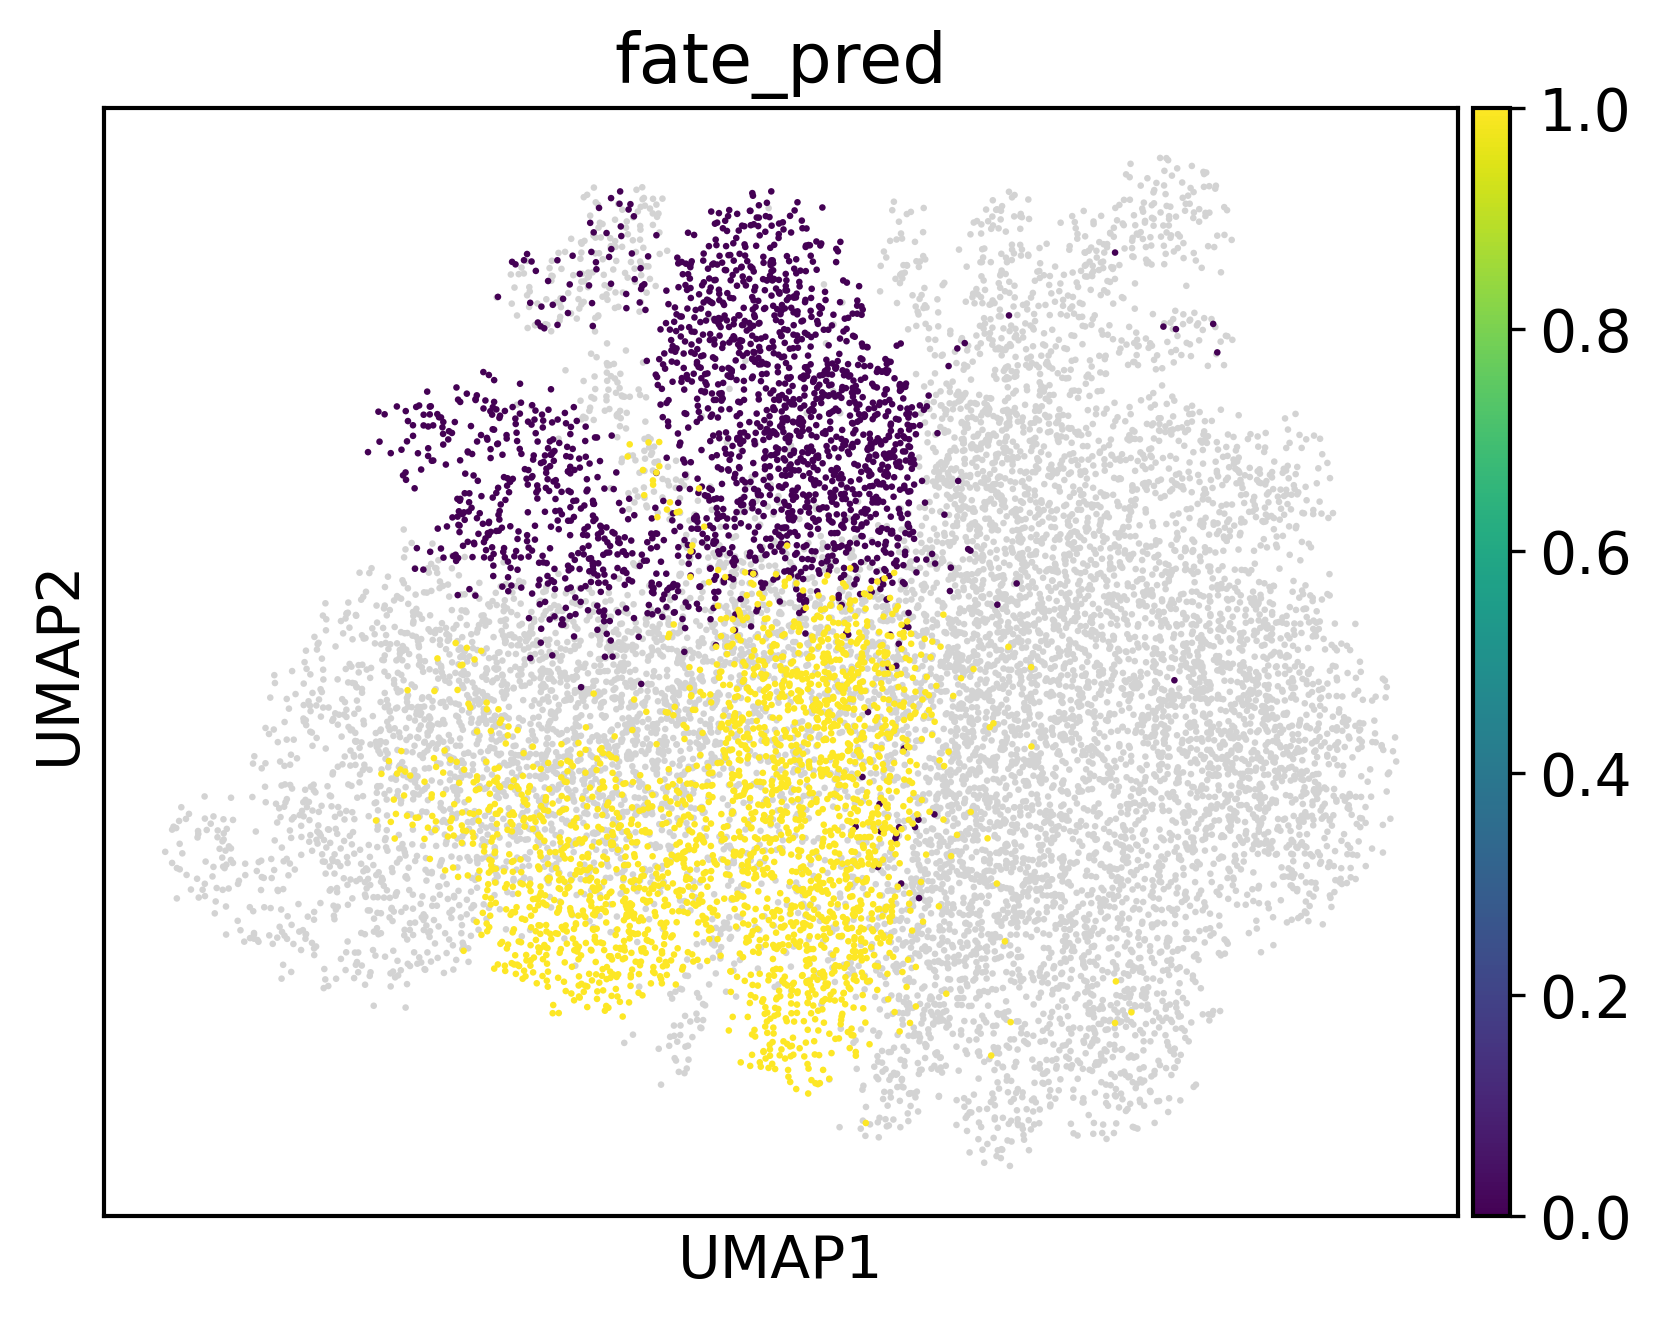

In [17]:
sc.pl.umap(adata3,color='fate_pred',s=10)

In [33]:
import seaborn as sns
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
def compute_gradients_for_label(target_label, data, model_encoder, model_decoder):
    mask = data.obs['fate_pred'] == target_label
    filtered_data = data[mask]
    
    geneex_data = torch.tensor(filtered_data.raw.X.toarray(), dtype=torch.float32).to(device2)
    
    dataset = TensorDataset(geneex_data)
    dataloader = DataLoader(dataset, batch_size=256, shuffle=False)
    
    total_gradients = torch.zeros(len_geneExp).to(device2)
    for batch in dataloader:
        geneExp = batch[0]
        geneExp = Variable(geneExp, requires_grad=True)
        output_data = model_encoder(geneExp)
        output_data = model_decoder(output_data)
        
        loss_function = nn.MSELoss()
        loss = loss_function(output_data, geneExp)
        
        model_encoder.zero_grad()
        model_decoder.zero_grad()
        loss.backward()

        total_gradients += geneExp.grad.abs().mean(dim=0)

    average_gradients = total_gradients / len(dataloader)
    return average_gradients

labels = [0, 1]
gradients_per_label = {}

for label in labels:
    gradients_per_label[label] = compute_gradients_for_label(label, adata3, geneEnc, geneDec)


In [34]:
num_key_genes = 50 

key_genes_per_label = {}

for label, gradients in gradients_per_label.items():
    df = pd.DataFrame({
        'gene_ids': adata3.var.index.values,
        'importance': gradients.cpu().detach().numpy()
    })
    sorted_df = df.sort_values(by="importance", ascending=False)
    key_genes = sorted_df['gene_ids'].head(num_key_genes).tolist()  
    key_genes_per_label[label] = key_genes
for label, genes in key_genes_per_label.items():
    print(f"Key genes for label {label}:")
    print(', '.join(genes))
    print("\n")


Key genes for label 0:
mt-Atp6, mt-Co1, mt-Co3, Mgp, S100a6, mt-Co2, Rps19, Rplp1, Rpl18a, mt-Cytb, Eef1a1, Rpl41, Rpl13a, mt-Nd1, Rpl37a, Actb, Rps14, Rps23, Rps8, Fth1, Rpl23, Rplp0, Rpl13, Rps20, Rps18, Lgals1, Rpl27a, Rps27, Rplp2, Ftl1, Rps2, Rps16, Rps15, Rpl23a, Rpl32, Rps27a, Rps29, Tpt1, Rpl37, Rpl19, Rps24, Rps15a, mt-Nd4, Rpl24, Rpl21, Rps9, Rpl10a, Rps28, Rpl18, Rpl17


Key genes for label 1:
mt-Co1, mt-Atp6, mt-Co3, Mgp, S100a6, mt-Co2, mt-Cytb, Rplp1, mt-Nd1, Rpl41, Actb, Rpl18a, Eef1a1, Rps19, Rpl13a, Apoa1, Rpl37a, Rps8, Rps14, Fth1, Rps2, Rps18, Rpl13, Ftl1, Rpl27a, Rplp2, Rplp0, Rpl23, Rps23, Rps16, Rps15, mt-Nd4, Rps20, Rpl19, Rpl32, Tpt1, Rpl18, Rps24, Rps29, Rpsa, Rps27a, Rpl21, Rpl37, Rpl14, Rps27, Rpl10a, 2200002D01Rik, Rpl23a, Rps9, Rps15a




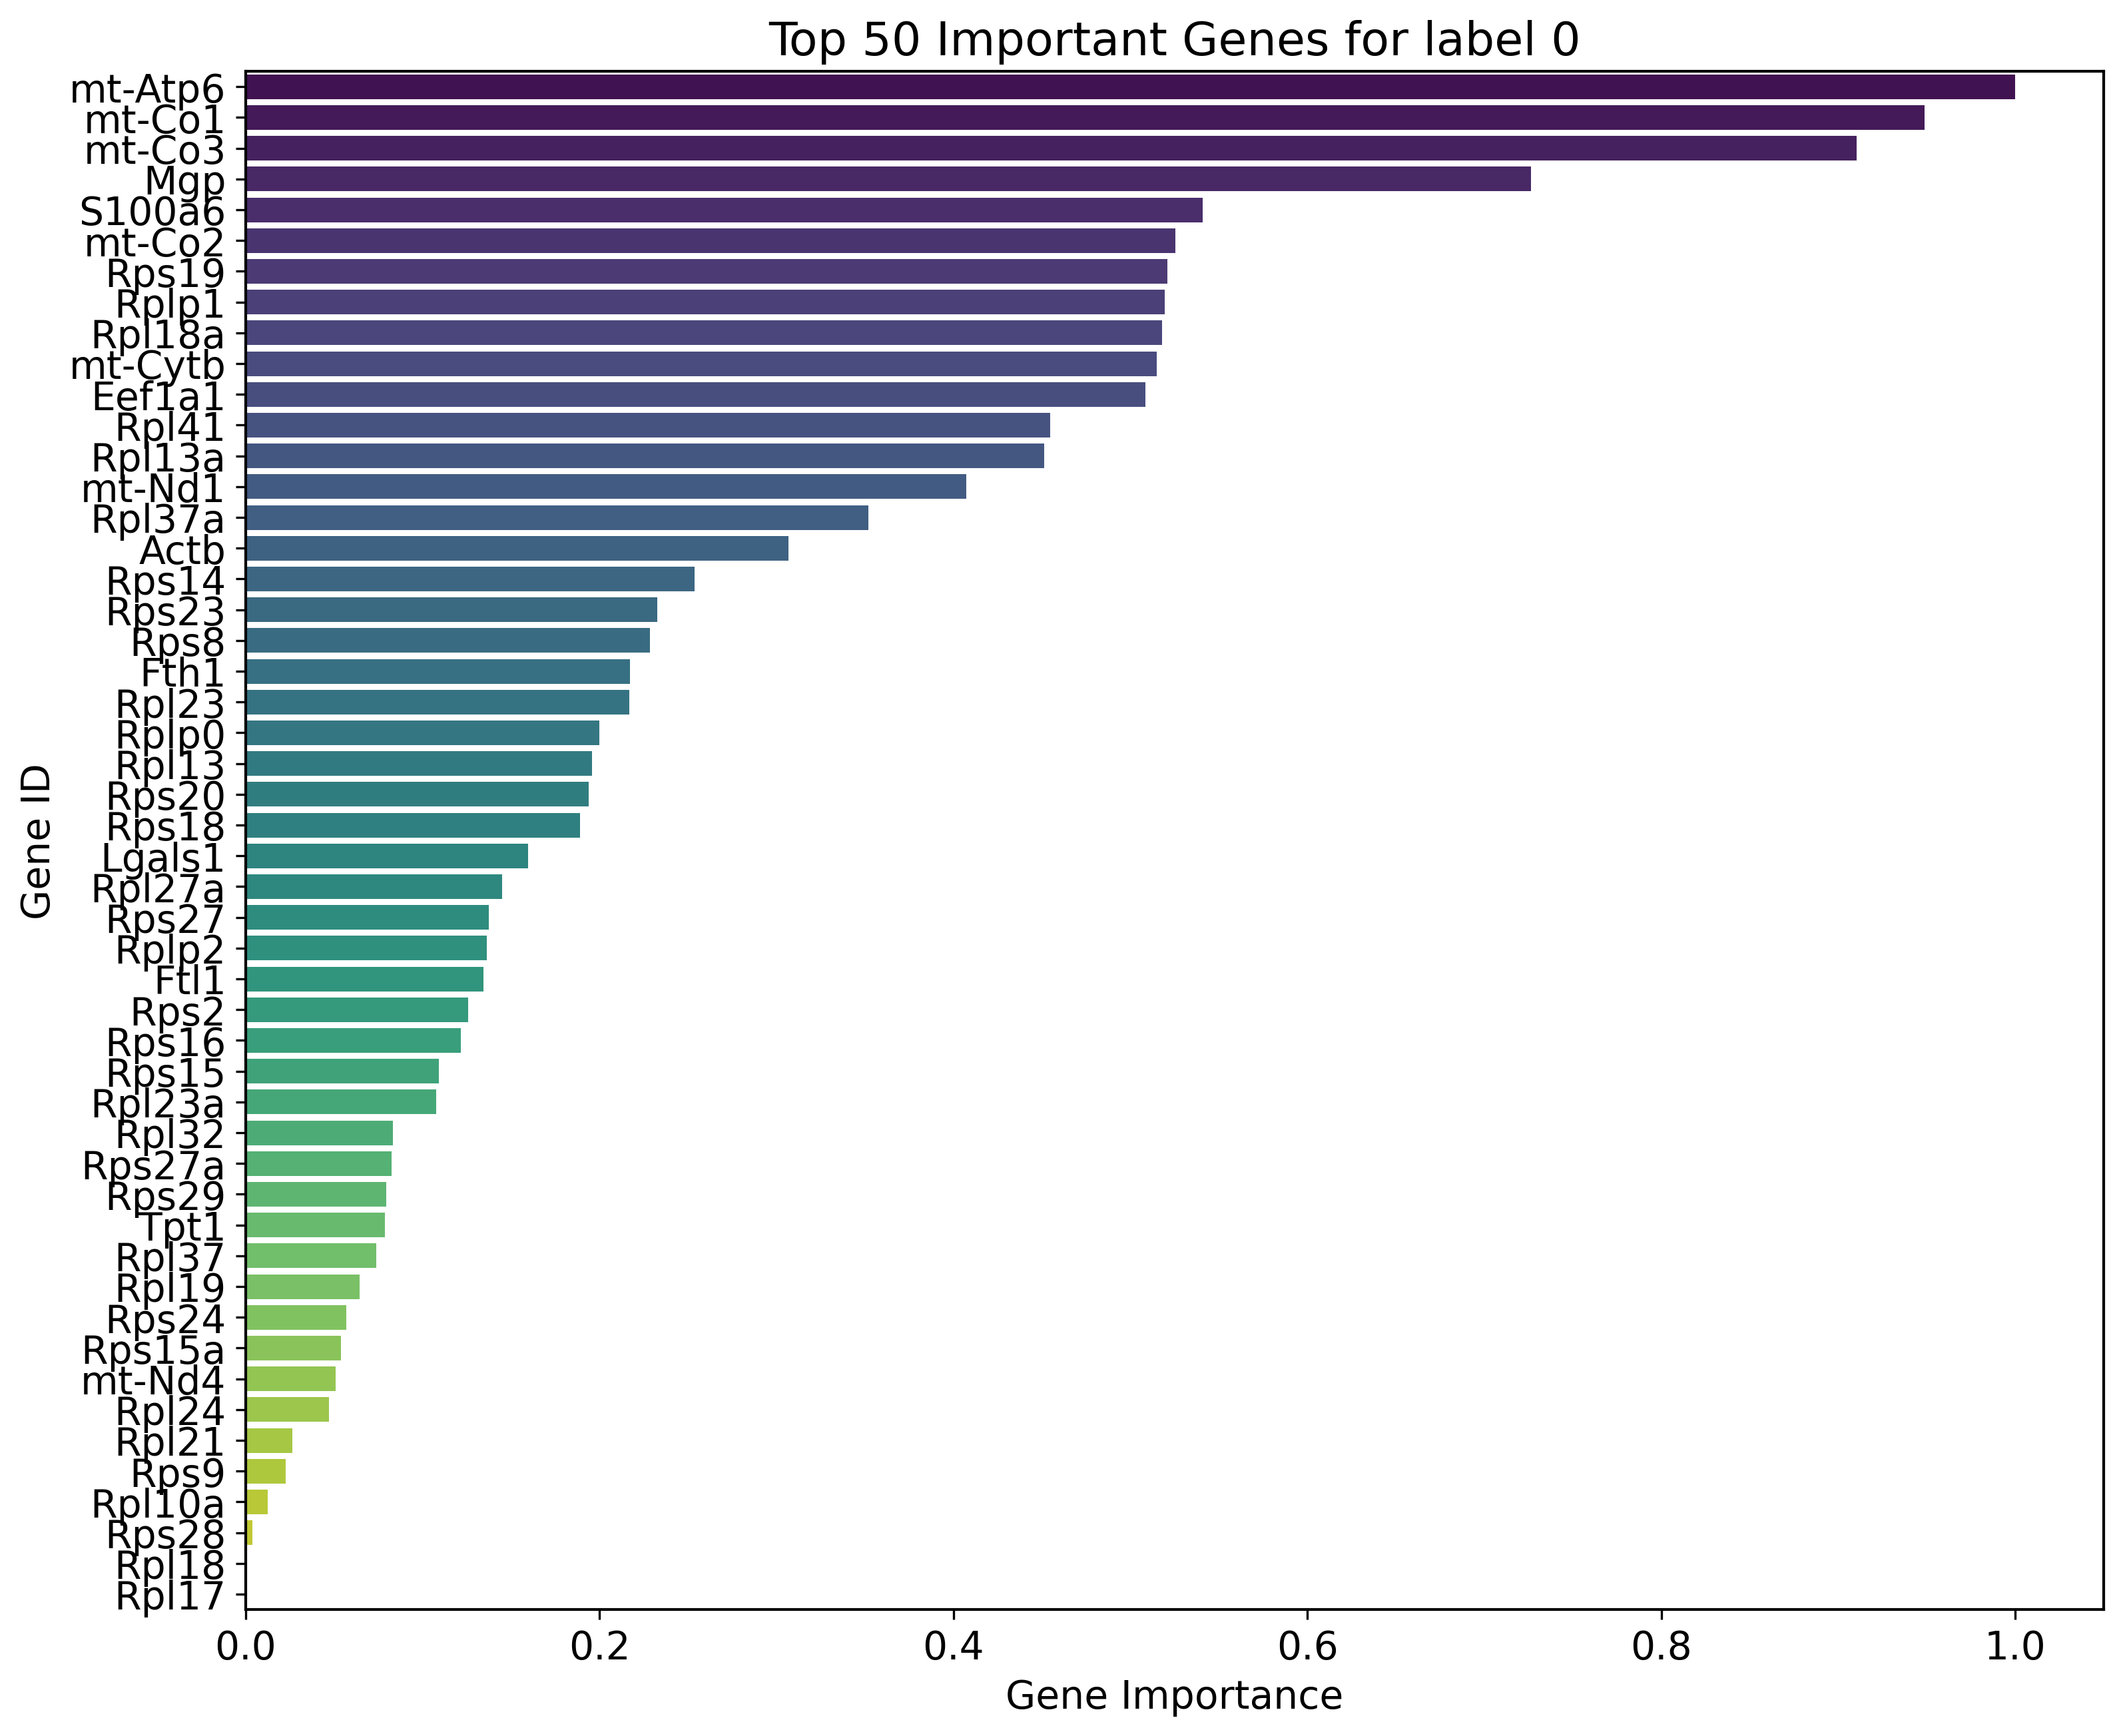

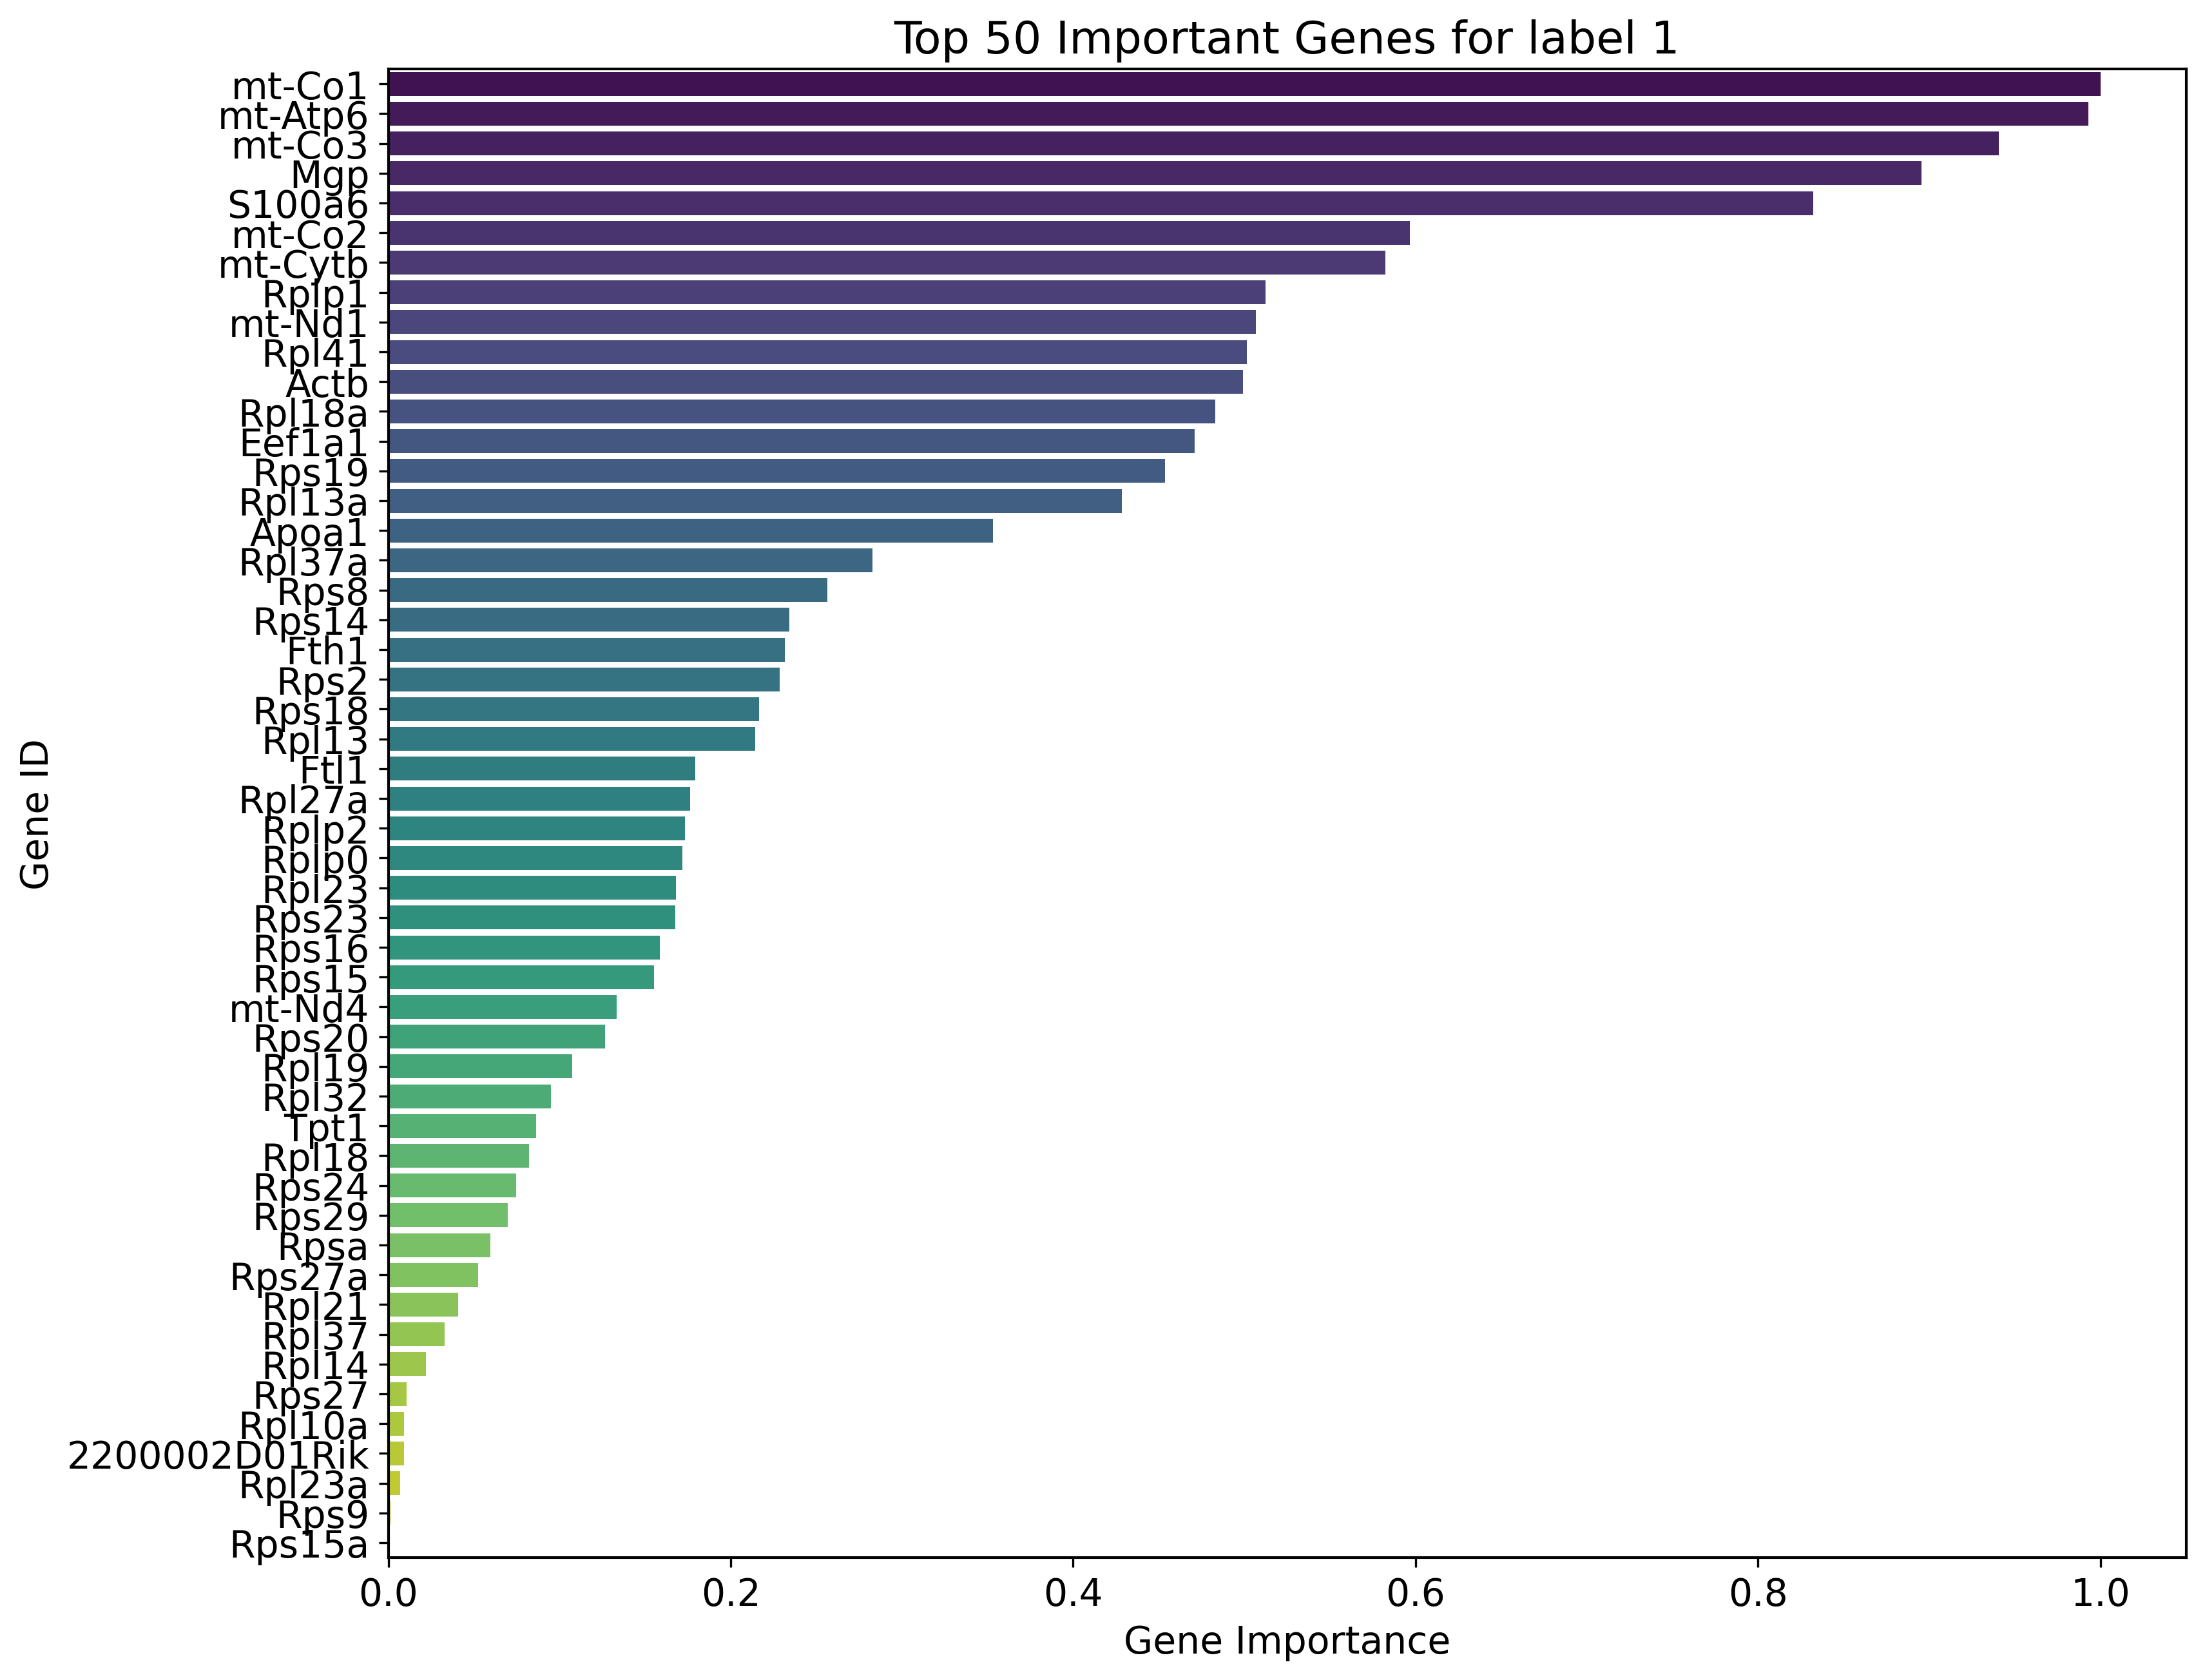

In [35]:
def normalize(array):
    min_val = array.min()
    max_val = array.max()
    return (array - min_val) / (max_val - min_val)

num_key_genes = 50

for label, gradients in gradients_per_label.items():
    df = pd.DataFrame({
        'gene_ids': adata3.var.index.values,
        'importance': gradients.cpu().detach().numpy()
    })

    sorted_df = df.sort_values(by="importance", ascending=False).head(num_key_genes)
    sorted_df['gene_importance'] = normalize(sorted_df['importance'])

    plt.figure(figsize=(12, 10))
    
    sns.barplot(x='gene_importance', y='gene_ids', data=sorted_df, palette='viridis')
    
    plt.title(f"Top {num_key_genes} Important Genes for label {label}")
    plt.xlabel('Gene Importance')
    plt.ylabel('Gene ID')
    plt.show()


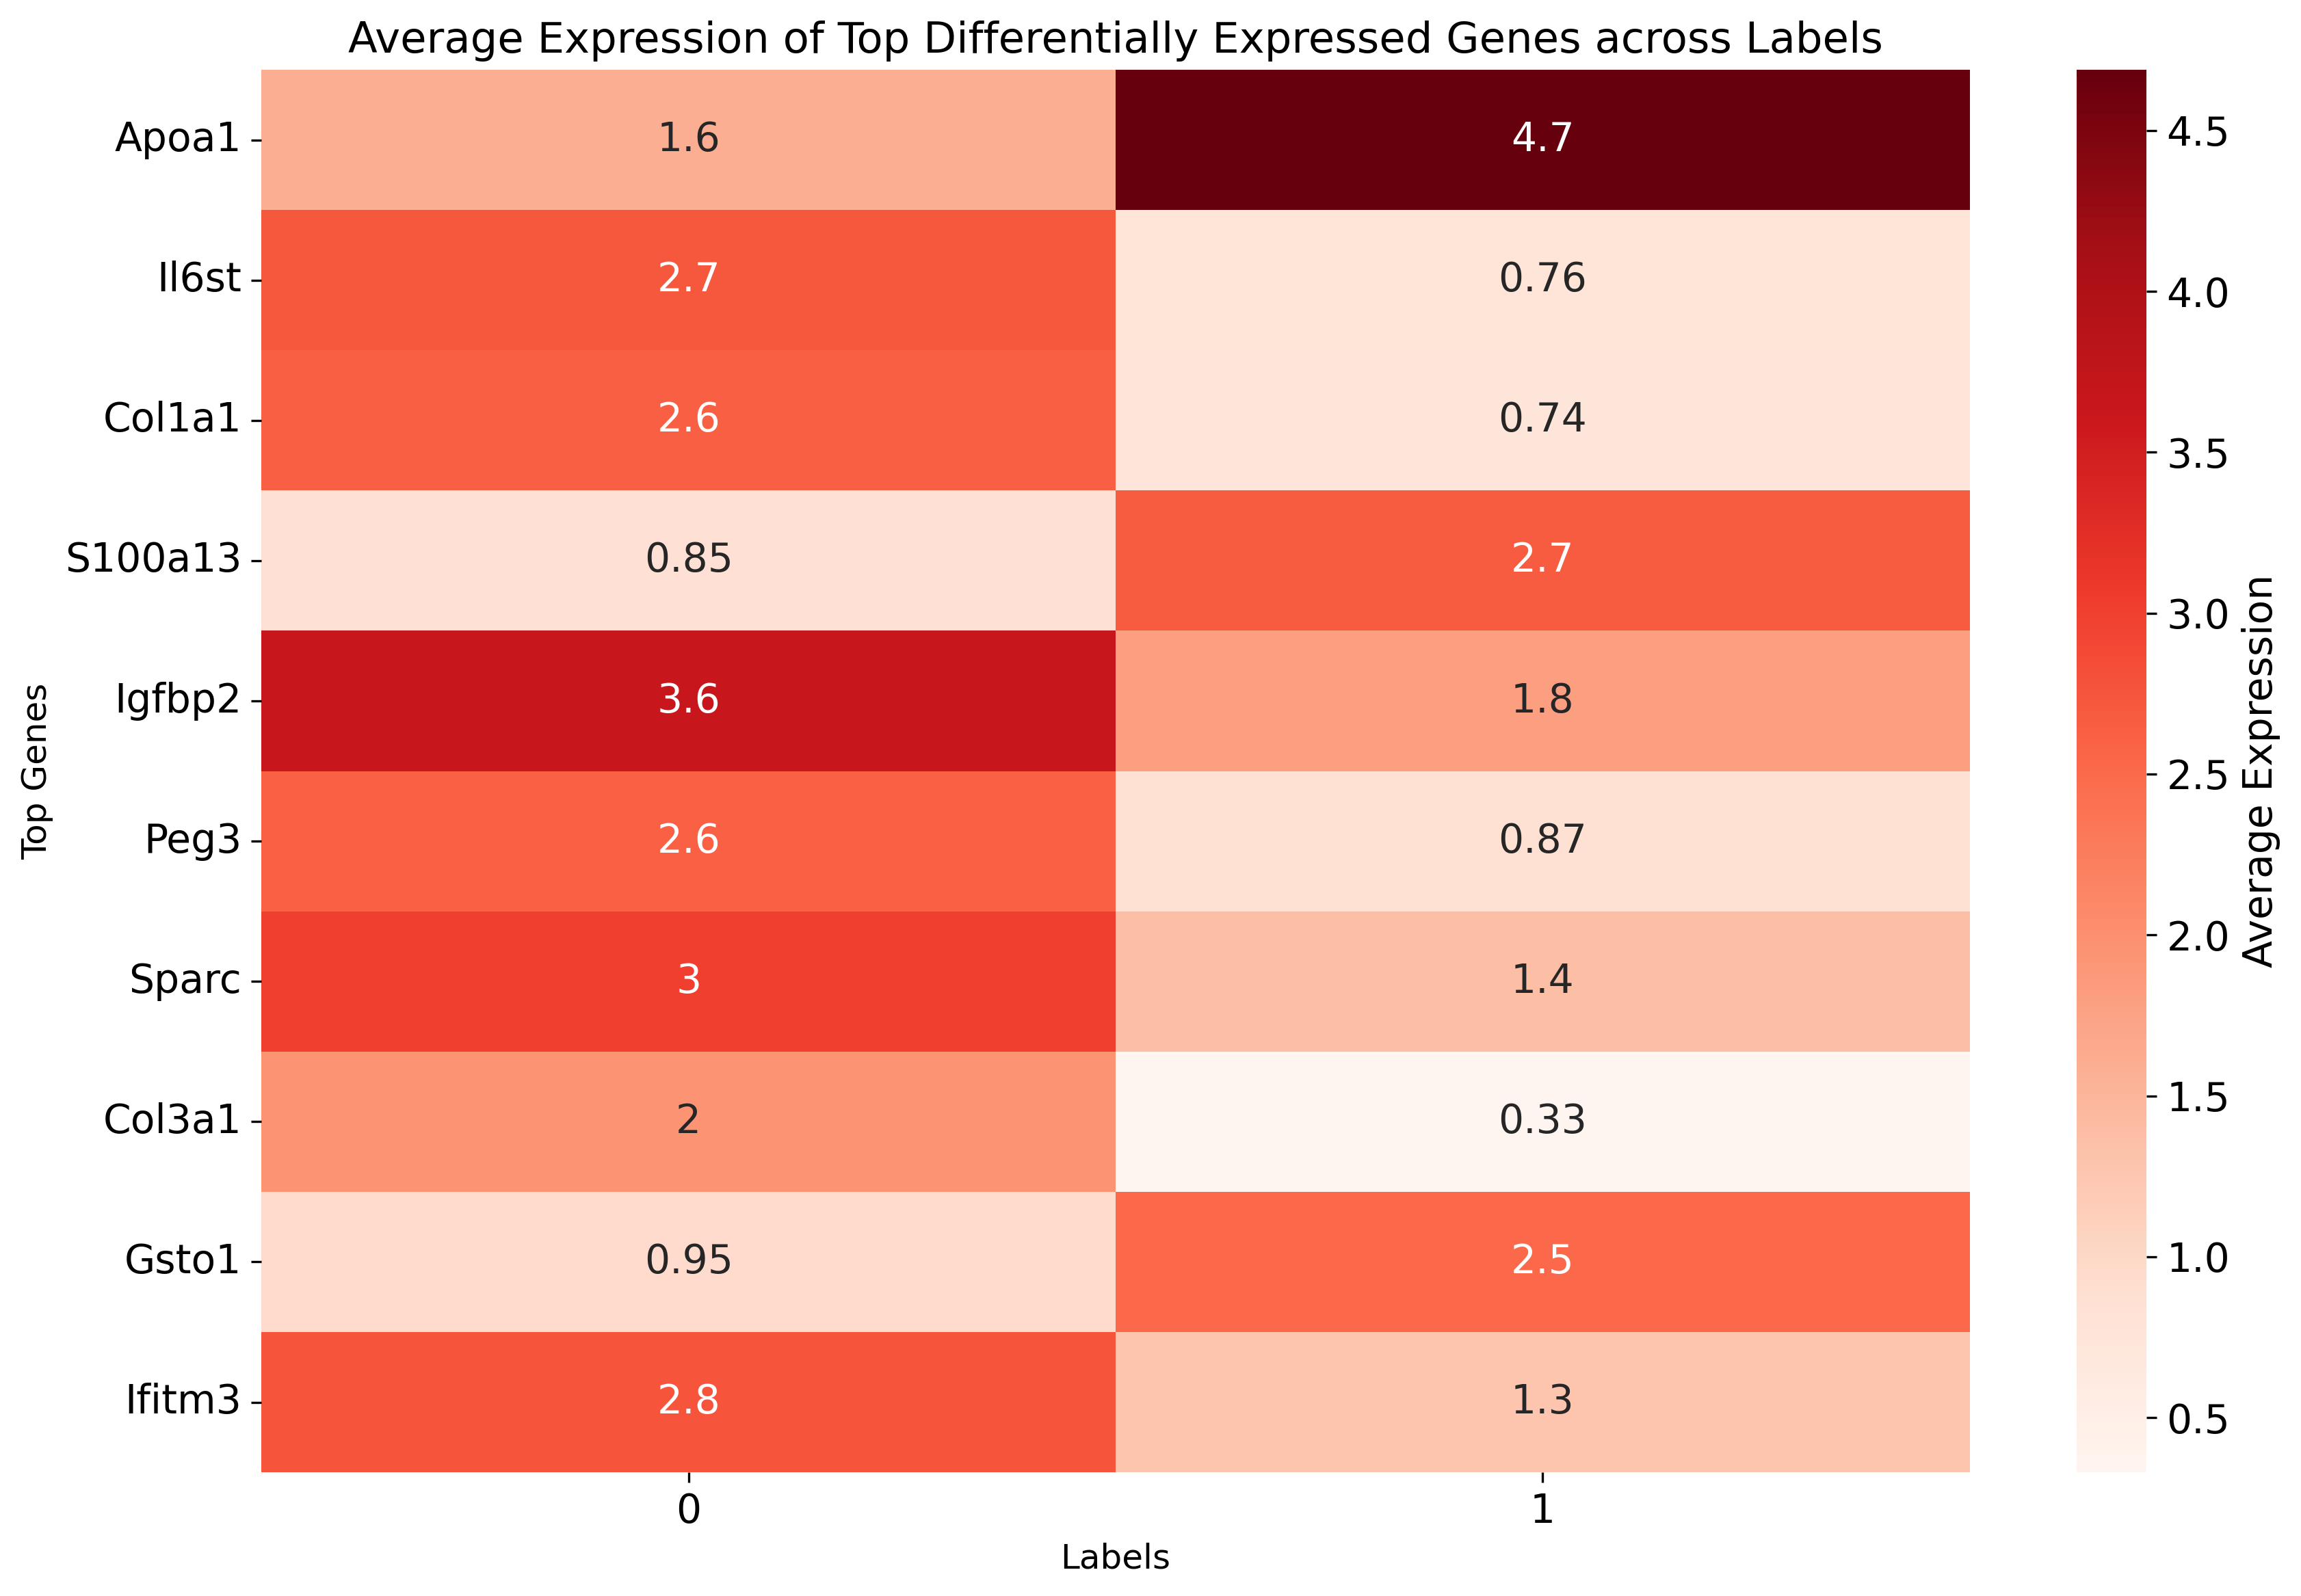

In [38]:
expression_data = {}

for label in labels:
    mask = adata3.obs['fate_pred'] == label
    avg_expression = adata3[mask].X.mean(axis=0).tolist()
    expression_data[label] = avg_expression

df_expression_all = pd.DataFrame(expression_data, index=adata3.var.index.values)


df_expression_all['diff'] = df_expression_all[labels[0]] - df_expression_all[labels[1]]

top_genes = df_expression_all['diff'].abs().nlargest(10).index

df_expression_top = df_expression_all.loc[top_genes, labels]

plt.figure(figsize=(12, 8))
sns.heatmap(df_expression_top, cmap="Reds", annot=True, cbar_kws={'label': 'Average Expression'})
plt.title("Average Expression of Top Differentially Expressed Genes across Labels", fontsize=15)
plt.ylabel('Top Genes', fontsize=12)
plt.xlabel('Labels', fontsize=12)
plt.tight_layout()
plt.show()



In [39]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # R -> W -> B
n_bins = 100
cmap_name = 'custom_div_cmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


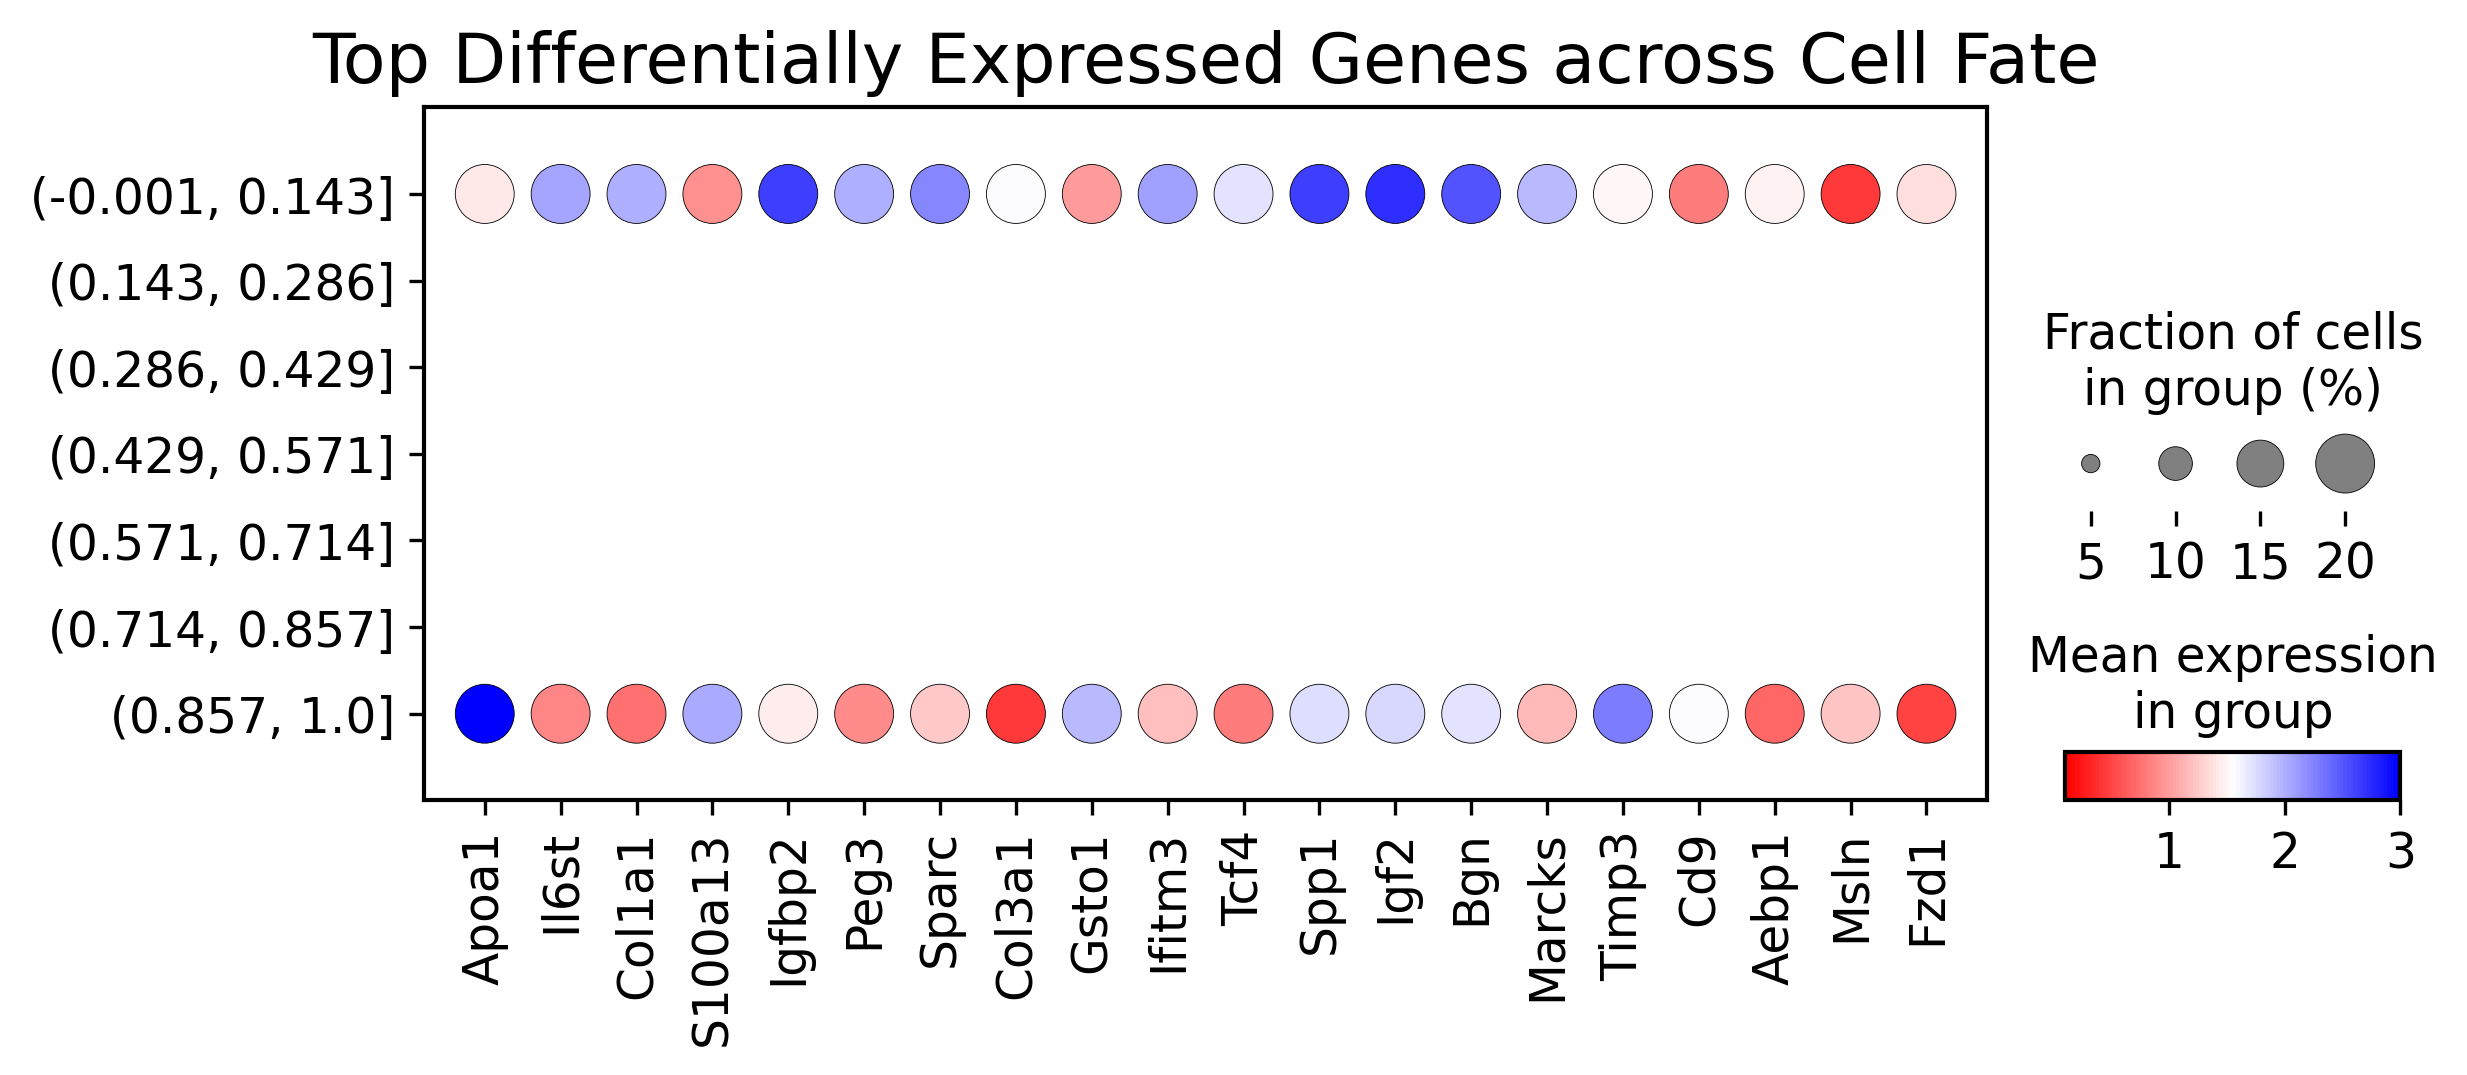

In [42]:
df_expression_all['diff'] = df_expression_all[labels[0]] - df_expression_all[labels[1]]

top_genes = df_expression_all['diff'].abs().nlargest(20).index

sc.pl.dotplot(adata3, 
              var_names=top_genes, 
              groupby='fate_pred', 
              figsize=(8.5, 3), 
              dot_max=0.2, 
              dot_min=0.01, 
              color_map=cm,
              title="Top Differentially Expressed Genes across Cell Fate",
              vmin=0.1,
              vmax=3)


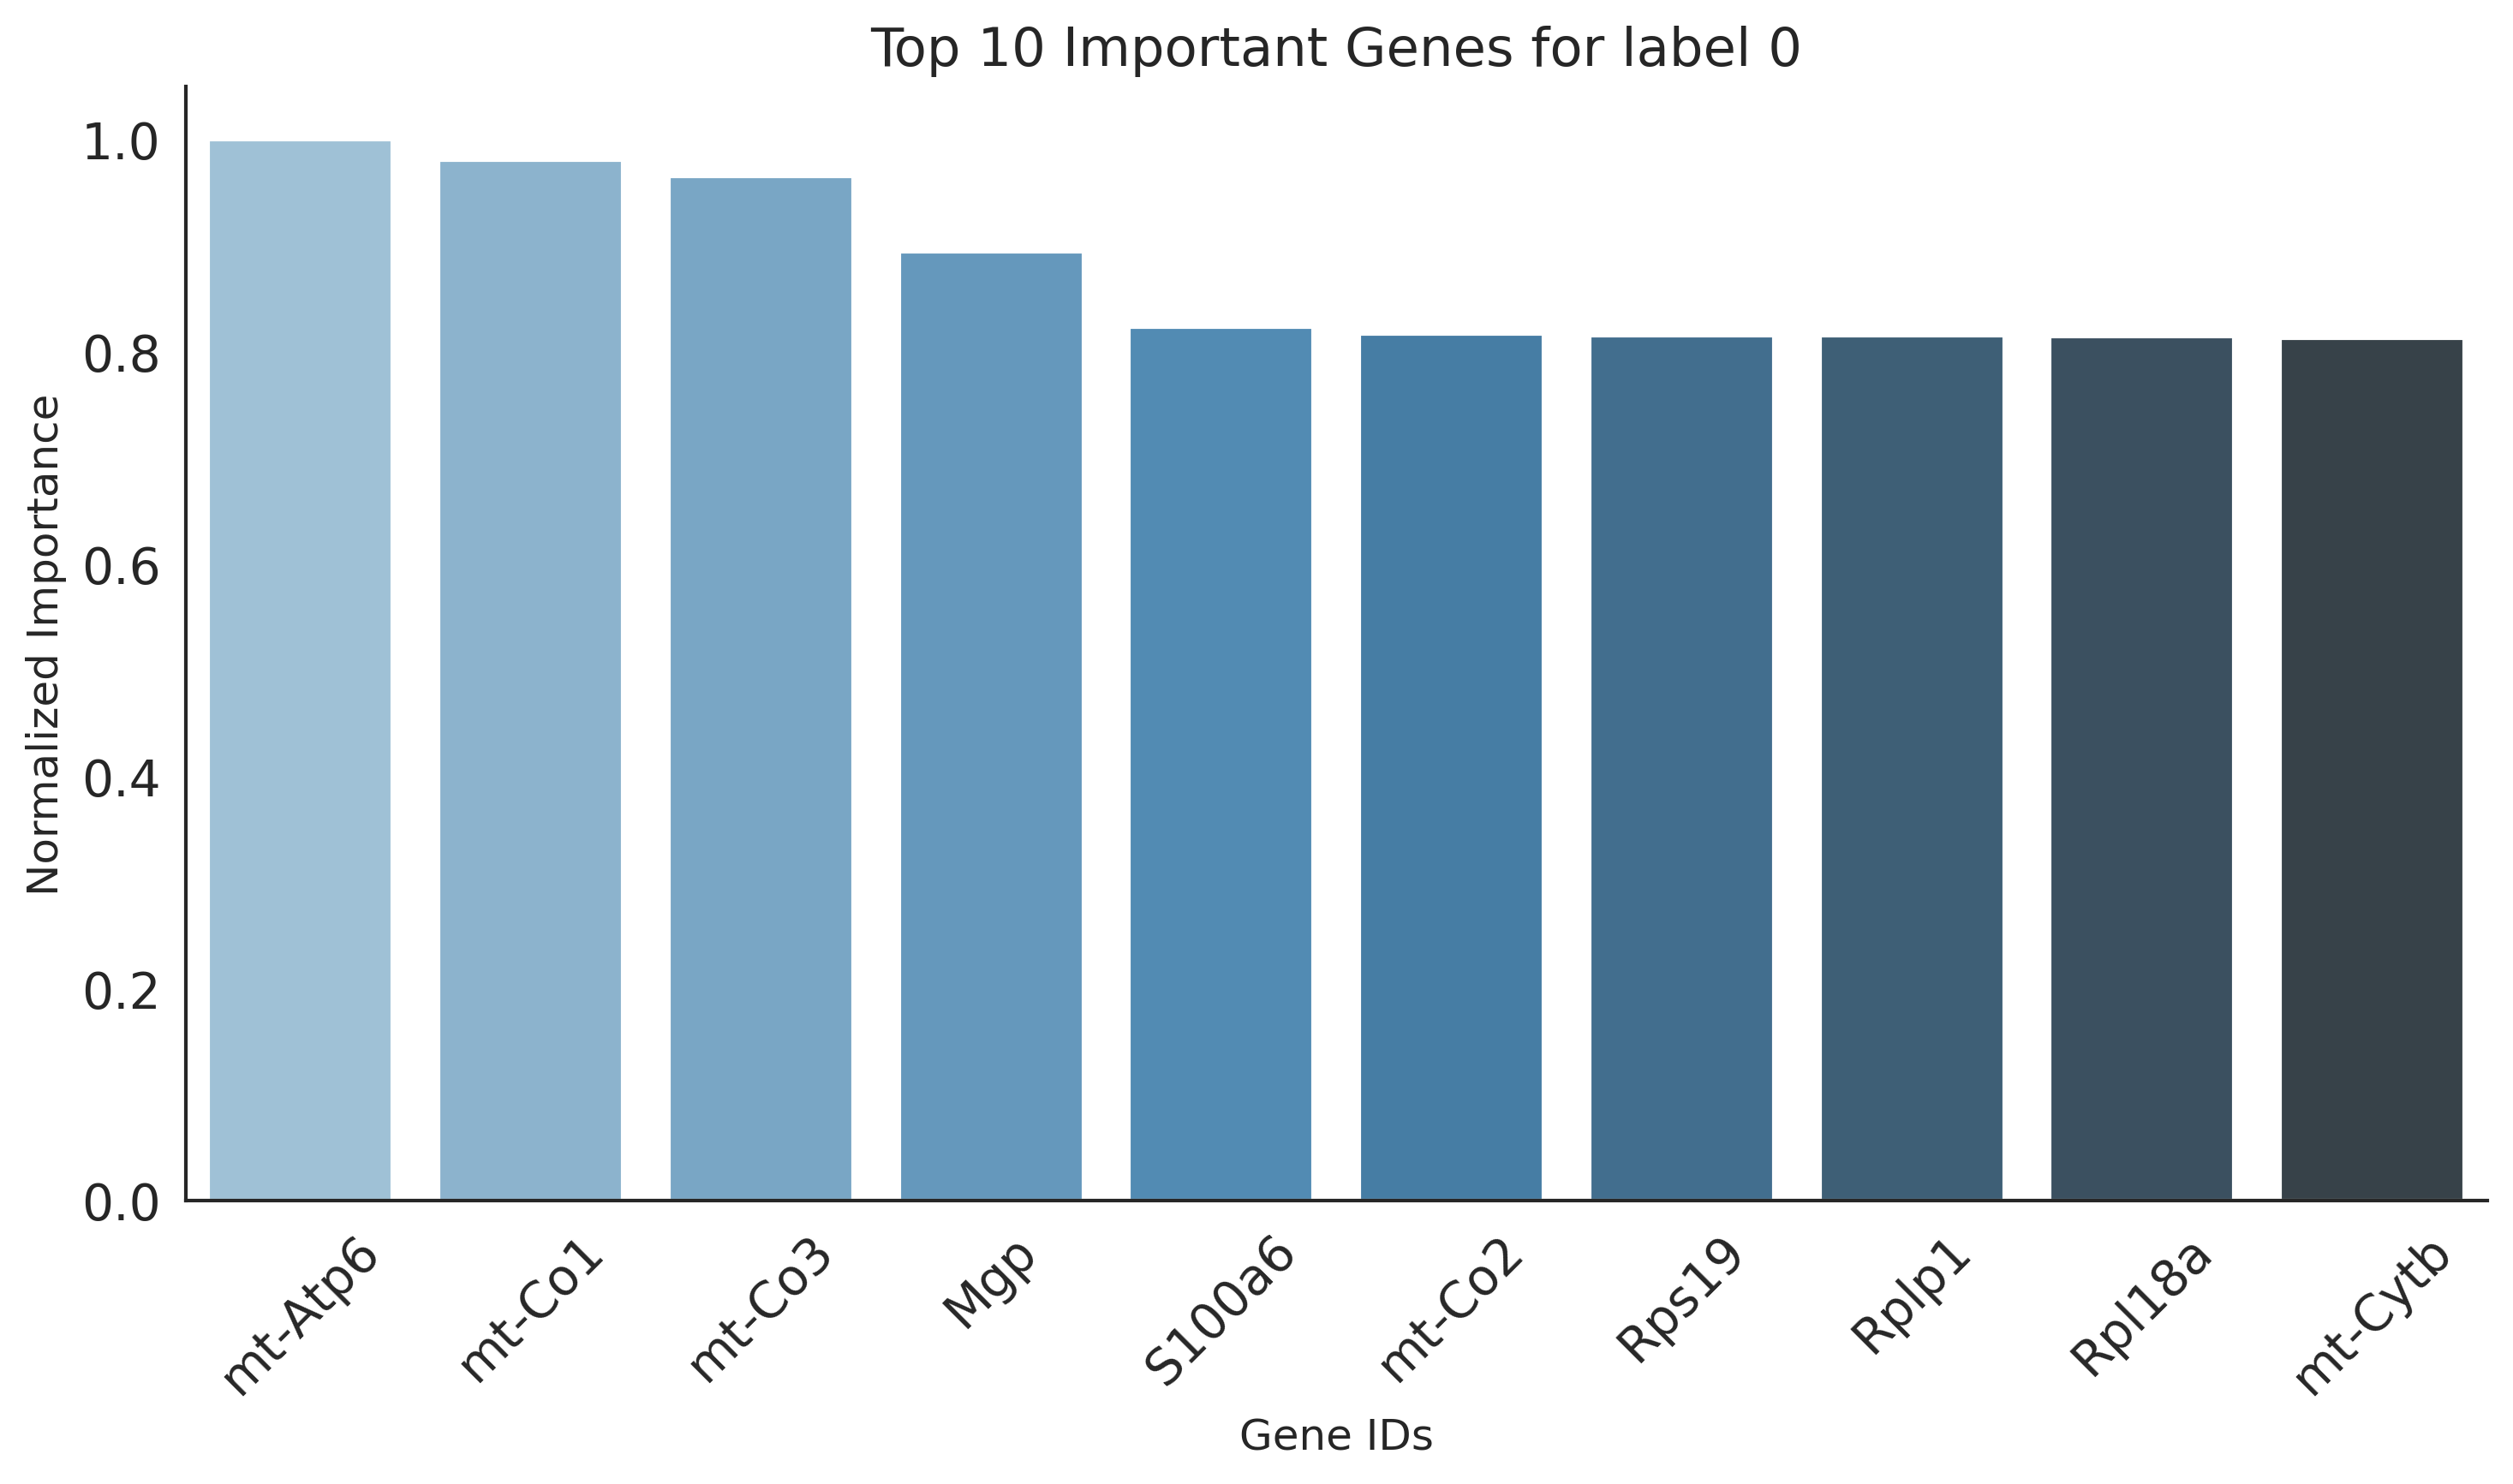

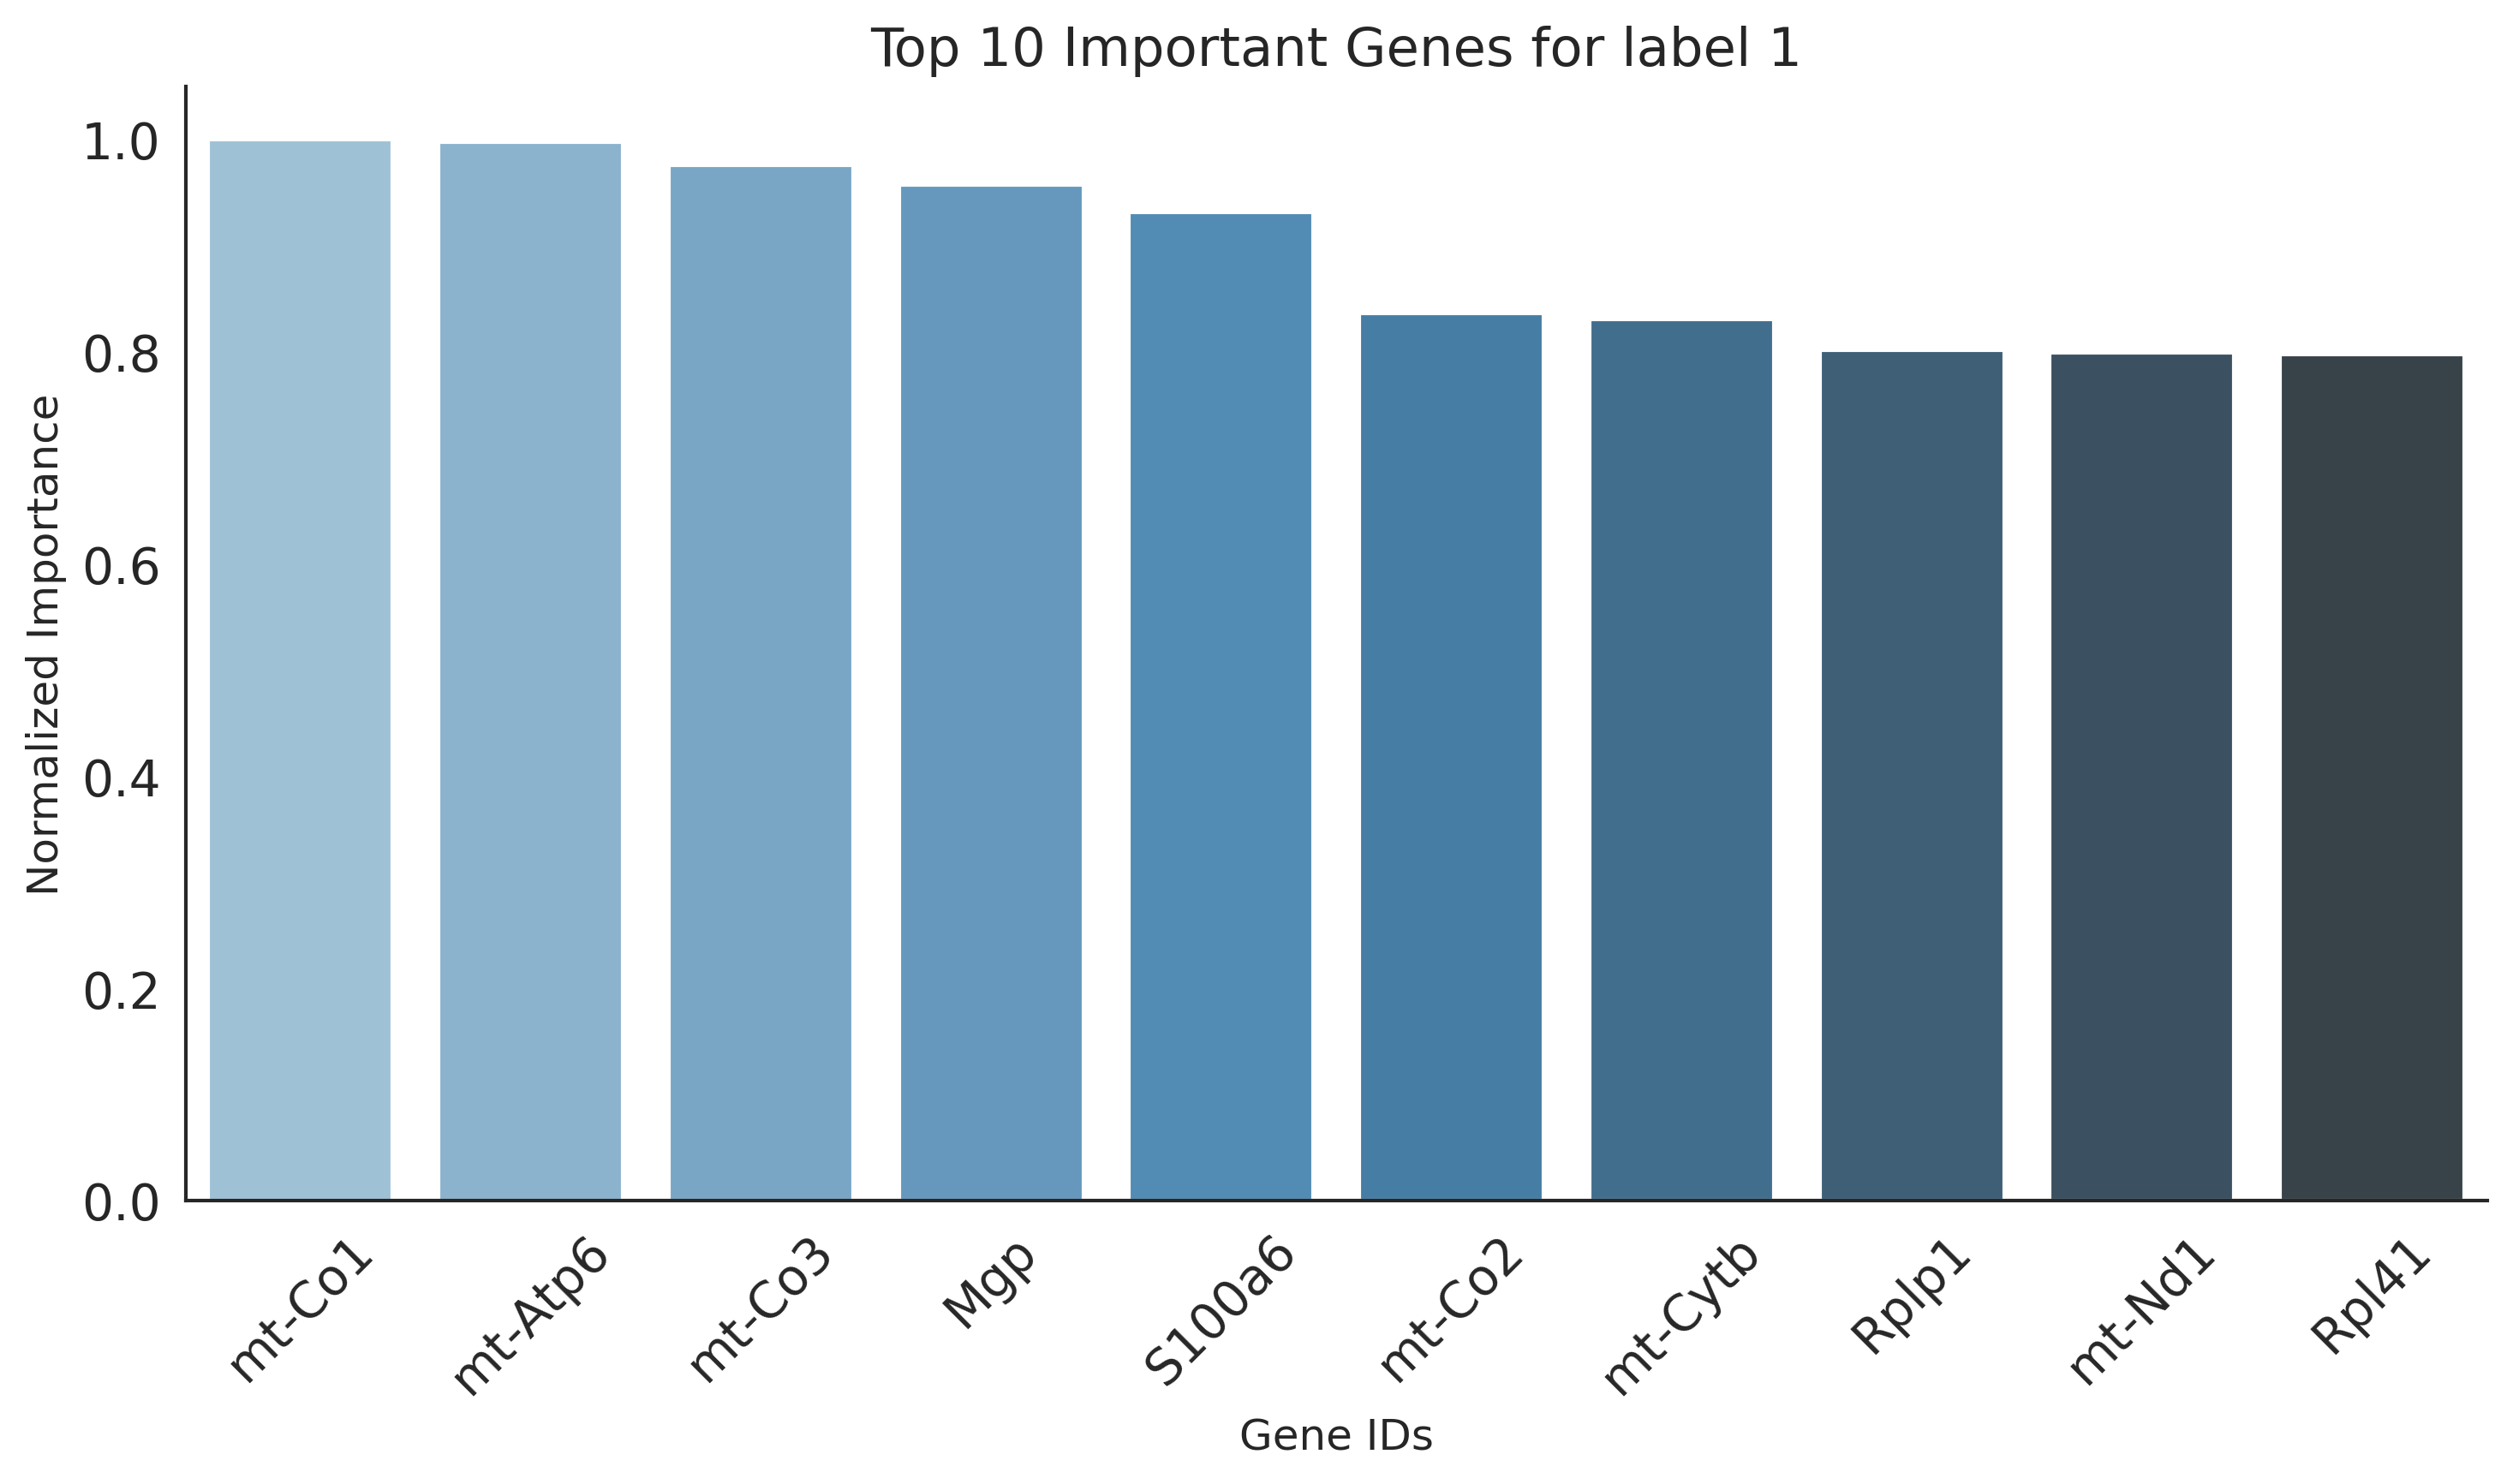

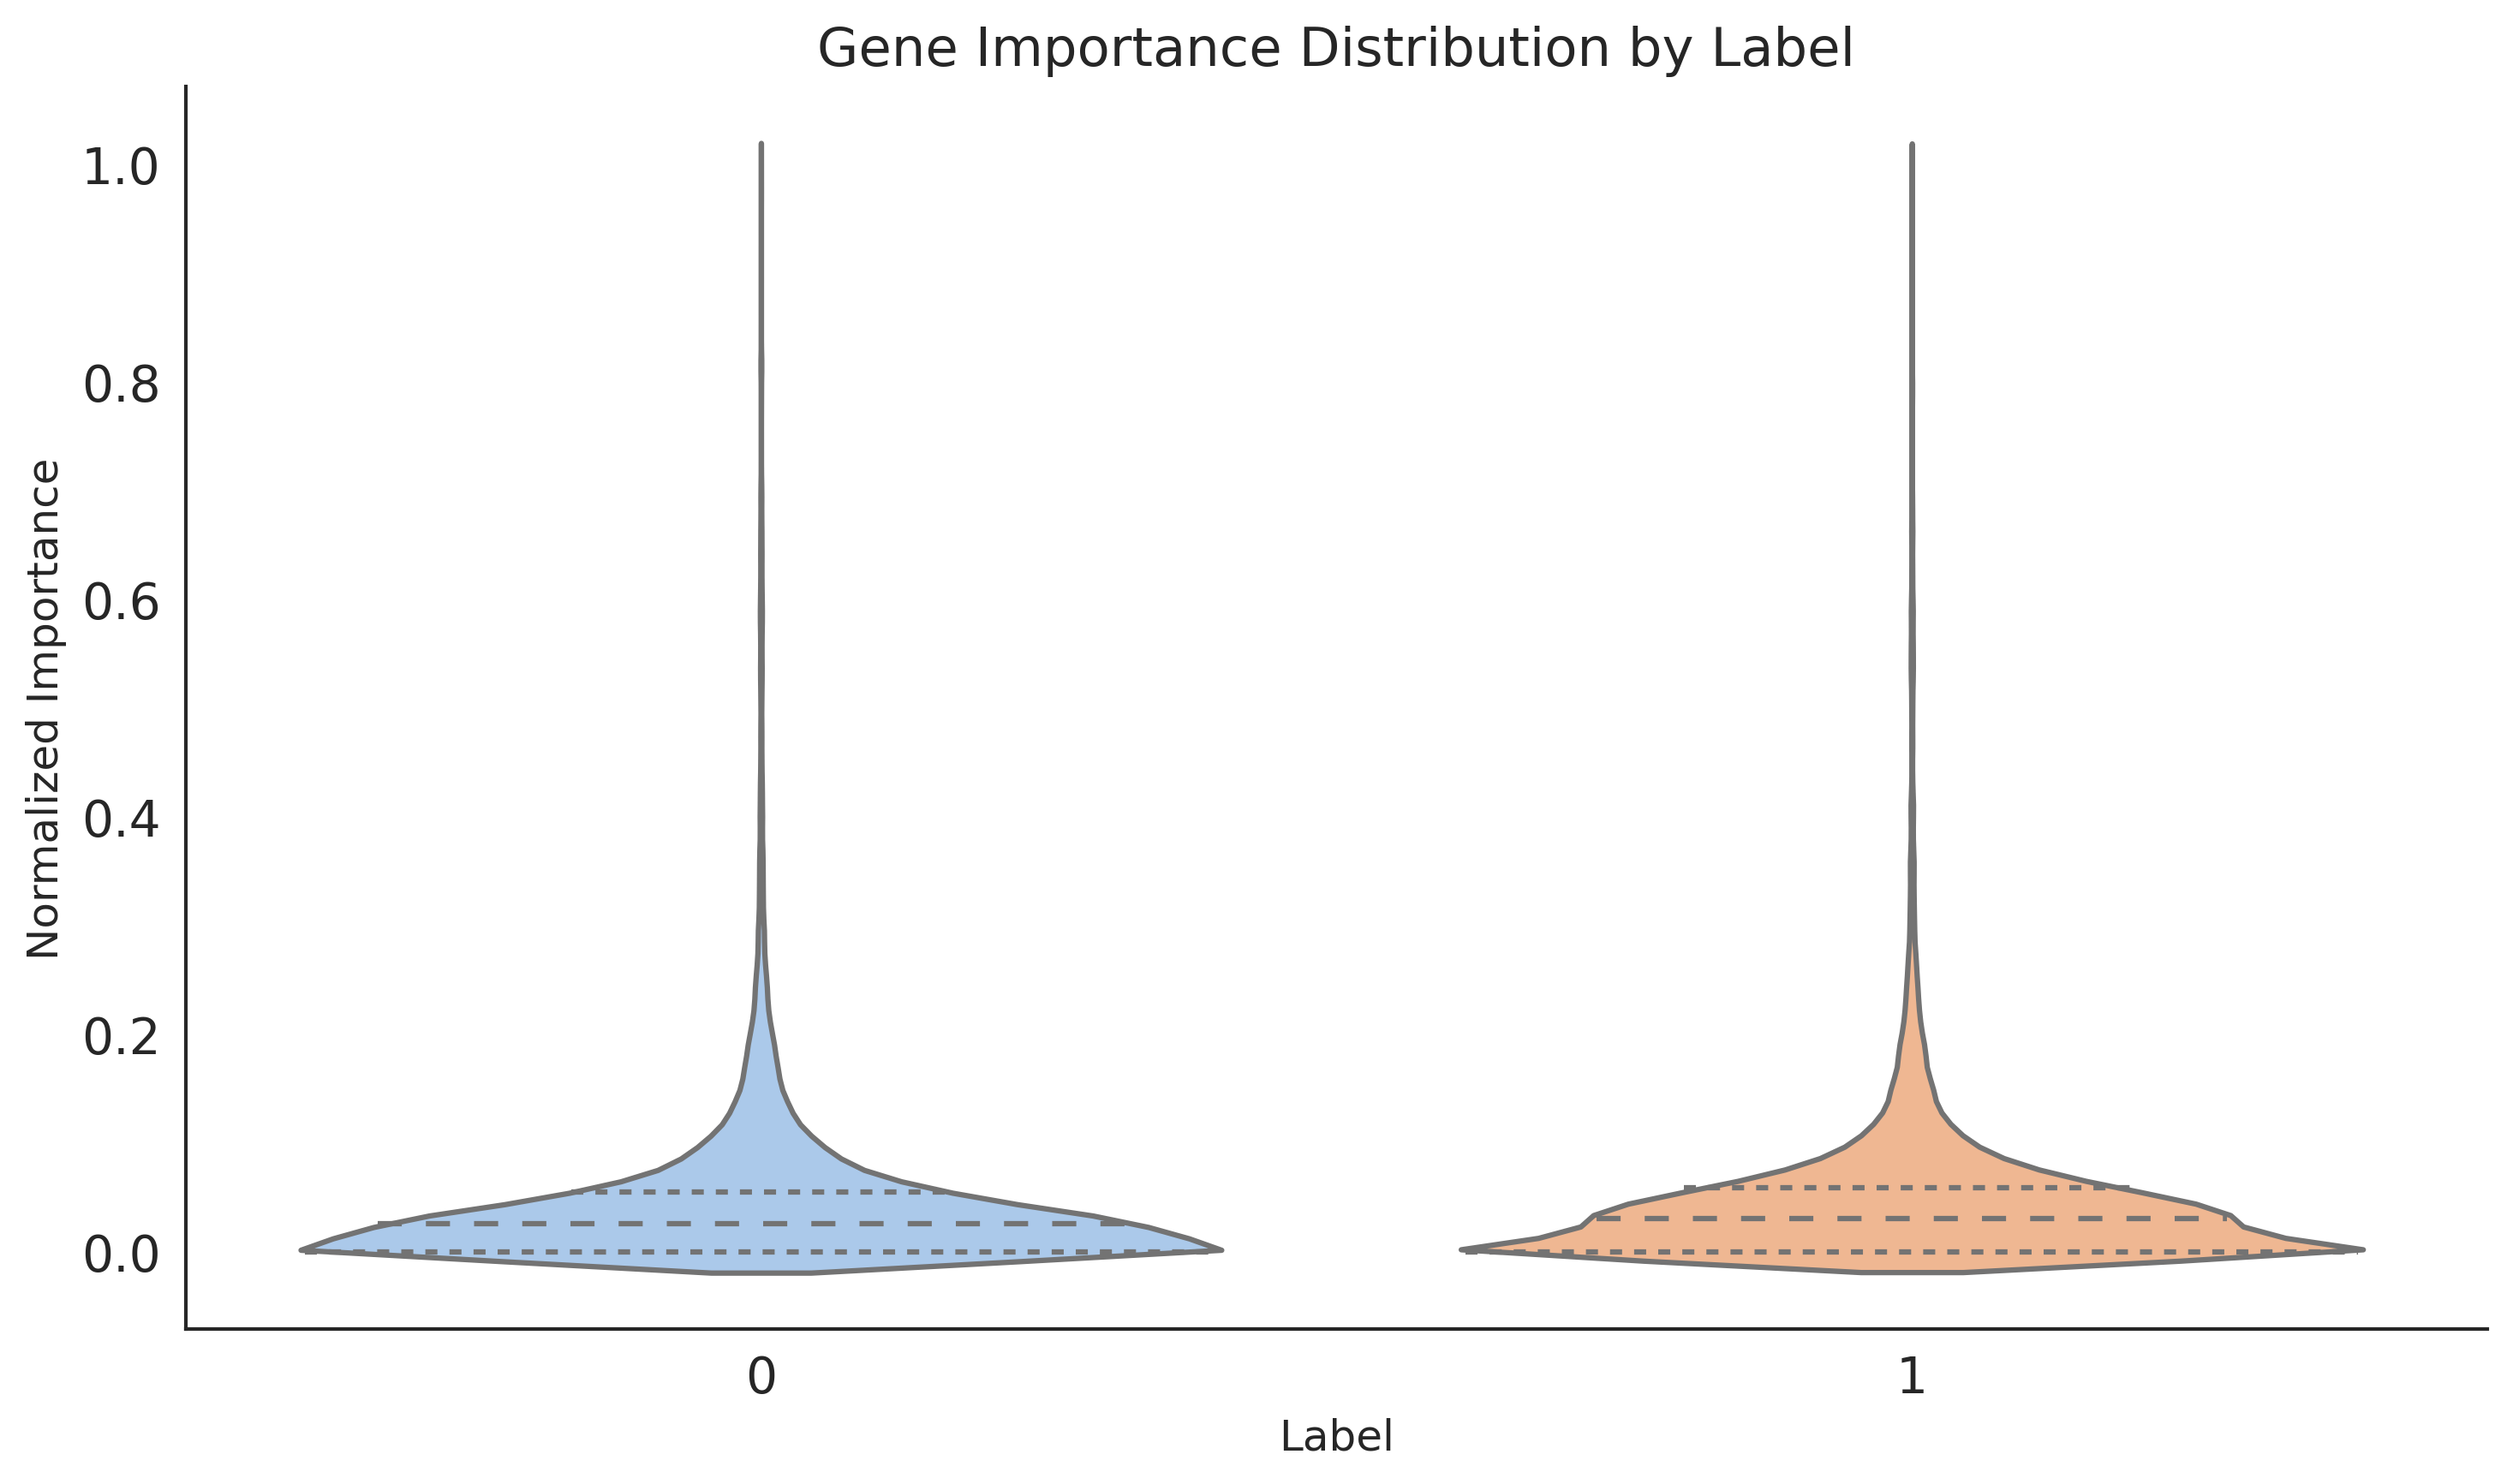

In [46]:
import numpy as np

def normalize_to_01(series):
    min_val = series.min()
    max_val = series.max()
    return (series - min_val) / (max_val - min_val)

sns.set_style("white")  
sns.set_palette("pastel")

N = 10 

for label, gradients in gradients_per_label.items():
    df = pd.DataFrame({
        'gene_ids': adata3.var.index.values,
        'importance': gradients.cpu().detach().numpy()
    })
    df['importance'] = normalize_to_01(df['importance'])
    df = df.nlargest(N, 'importance')
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='gene_ids', y='importance', data=df, palette="Blues_d")
    plt.title(f"Top {N} Important Genes for label {label}", fontsize=15)
    plt.ylabel('Normalized Importance', fontsize=12)
    plt.xlabel('Gene IDs', fontsize=12)
    plt.xticks(rotation=45)
    sns.despine()  
    plt.tight_layout()  
    plt.show()

data_frames = []

for label, gradients in gradients_per_label.items():
    df = pd.DataFrame({
        'gene_ids': adata3.var.index.values,
        'importance': gradients.cpu().detach().numpy(),
        'label': label
    })
    df['importance'] = normalize_to_01(df['importance'])
    data_frames.append(df)

all_data = pd.concat(data_frames)

plt.figure(figsize=(10, 6))
sns.violinplot(x='label', y='importance', data=all_data, inner="quartile")
plt.title("Gene Importance Distribution by Label", fontsize=15)
plt.ylabel('Normalized Importance', fontsize=12)
plt.xlabel('Label', fontsize=12)
sns.despine()  
plt.tight_layout()
plt.show()
